# BERT - Hyperparameter Tuning

### Setup

### Import Libraries


In [1]:
!pip install -q optuna
!pip install -q evaluate
!pip install -q emoji==0.6.0
!pip install -q tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from sklearn.model_selection import train_test_split
from pathlib import Path
from sklearn.metrics import *
import json
from sklearn.preprocessing import LabelEncoder
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_scheduler


import optuna
import wandb

import time
from tqdm import tqdm
import logging

from sklearn.metrics import classification_report, precision_recall_fscore_support
import pandas as pd

from torch.cuda.amp import autocast, GradScaler

### Device Configuration

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
### Weights & Biases Setup

wandb.login(key="<wandb key>")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mayachn3 (mayachn3-maya-bondar) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

## Load Dataset

In [7]:
train = pd.read_csv("OOT_train.csv", encoding='latin-1')
val = pd.read_csv("OOT_val.csv", encoding='latin-1')
test = pd.read_csv("OOT_test.csv", encoding='latin-1')


In [8]:
# train = train.head(100)
# val = val.head(100)
# test = test.head(100)

### Preprocessing

In [9]:
#encoding the labels numerically from Sentiment
ordinal_mapping = {
    'Extremely Negative': 0,
    'Negative': 1,
    'Neutral': 2,
    'Positive': 3,
    'Extremely Positive': 4
}

# map to ordinal labels
train["label_id"] = train["Sentiment"].map(ordinal_mapping)
val["label_id"] = val["Sentiment"].map(ordinal_mapping)
test["label_id"] = test["Sentiment"].map(ordinal_mapping)



In [10]:
# Concat the relevant columns into one string with seperation.
# for example: "Tweet: my food stock is low | Location: Canada | Date: 2020-03-17 | URL: https://t.co/abcd"

# Function to build the input string from multiple columns
def build_augmented_input(row):
    parts = []

    if pd.notna(row.get('clean_tweet')):
        parts.append(f"{row['clean_tweet']}")

    if pd.notna(row.get('Location_standardized')) and row['Location_standardized'].lower() != 'unknown':
        parts.append(f"{row['Location_standardized']}")

    if pd.notna(row.get('TweetAt')):
        parts.append(f"{row['TweetAt']}")

    return " | ".join(parts)

# Apply to the DataFrames
train['model_input'] = train.apply(build_augmented_input, axis=1)
val['model_input'] = val.apply(build_augmented_input, axis=1)
test['model_input'] = test.apply(build_augmented_input, axis=1)

# Create new DataFrames with only what's needed for modeling
formatted_train = train[['model_input', 'label_id']].copy()
formatted_val = val[['model_input', 'label_id']].copy()
formatted_test = test[['model_input', 'label_id']].copy()



In [11]:
def balance_dataset(df, target_samples_per_class=5000):
    """Balance dataset by undersampling"""
    balanced_dfs = []

    print("Original class distribution:")
    print(df['label_id'].value_counts().sort_index())

    for class_id in range(5):
        class_data = df[df['label_id'] == class_id]

        if len(class_data) > target_samples_per_class:
            class_data = class_data.sample(n=target_samples_per_class, random_state=42)
            print(f"Class {class_id}: {len(class_data)} samples (undersampled)")
        else:
            print(f"Class {class_id}: {len(class_data)} samples (kept all)")

        balanced_dfs.append(class_data)

    balanced_df = pd.concat(balanced_dfs, ignore_index=True).sample(frac=1, random_state=42)

    print(f"Balanced dataset: {len(balanced_df)} total samples")
    print("New distribution:")
    print(balanced_df['label_id'].value_counts().sort_index())

    return balanced_df

# Apply balancing to training data
formatted_train = balance_dataset(formatted_train, target_samples_per_class=5000)

Original class distribution:
label_id
0     5175
1     9230
2     6784
3    10140
4     5845
Name: count, dtype: int64
Class 0: 5000 samples (undersampled)
Class 1: 5000 samples (undersampled)
Class 2: 5000 samples (undersampled)
Class 3: 5000 samples (undersampled)
Class 4: 5000 samples (undersampled)
Balanced dataset: 25000 total samples
New distribution:
label_id
0    5000
1    5000
2    5000
3    5000
4    5000
Name: count, dtype: int64


## Tokenization and Dataset Preparation

In [12]:
model_name = "finiteautomata/bertweet-base-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_data(data, max_length=128):
    return tokenizer(
        data['model_input'].tolist(),
        truncation=True,
        padding='max_length',
        max_length=max_length,
        add_special_tokens=True,
        return_attention_mask=True,
        return_token_type_ids=False
    )

train_encodings = tokenize_data(formatted_train)
val_encodings = tokenize_data(formatted_val)
test_encodings = tokenize_data(formatted_test)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/338 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

In [ ]:
## define a PyTorch Dataset
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])  # For training
        return item

    def __len__(self):
        return len(self.labels)

# Convert labels to integers if not already
train_labels = formatted_train['label_id'].tolist()
val_labels = formatted_val['label_id'].tolist()
test_labels = formatted_test['label_id'].tolist()


train_dataset = TweetDataset(train_encodings, train_labels)
val_dataset = TweetDataset(val_encodings, val_labels)
test_dataset = TweetDataset(test_encodings, test_labels)


In [14]:

# define mapping between label id and sentiment for later use and conveniency
ordinal_label2id = ordinal_mapping
ordinal_id2label = {v: k for k, v in ordinal_mapping.items()}


### Model

In [15]:
def save_training_checkpoint(model, optimizer, scheduler, epoch, loss, trial_params, filepath, trial_number, current_score, best_score, model_name="finiteautomata/bertweet-base-sentiment-analysis"):
    """Save complete training checkpoint and handle best model updates"""
    global global_best_qwk, global_best_model_state

    # Get the trial directory from filepath
    trial_dir = os.path.dirname(filepath)

    # Save trial checkpoint
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict() if optimizer else None,
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'loss': loss,
        'trial_params': trial_params,
        'model_config': model.config.to_dict(),
        'model_name': model_name,
        'current_score': current_score,
        'trial_number': trial_number,
    }

    # Save all trial files in the same directory
    torch.save(checkpoint, filepath)
    torch.save(model.state_dict(), os.path.join(trial_dir, 'model_bert_weights.pt'))
    torch.save(model, os.path.join(trial_dir, 'model_bert.pt'))

    print(f"✅ Trial checkpoint saved: {filepath}")
    print(f"✅ Model files saved in: {trial_dir}")

    # Update best model if needed
    if current_score > best_score:
        best_model_path = "./best_bert_model_so_far"

        # Ensure best model directory exists
        os.makedirs(best_model_path, exist_ok=True)

        # Save our custom .pt files in best model directory
        best_checkpoint_path = os.path.join(best_model_path, 'best_checkpoint.ckpt')
        best_weights_path = os.path.join(best_model_path, 'model_bert_weights.pt')
        best_model_file_path = os.path.join(best_model_path, 'model_bert.pt')

        torch.save(checkpoint, best_checkpoint_path)
        torch.save(model.state_dict(), best_weights_path)
        torch.save(model, best_model_file_path)

        # Update global variables
        global_best_qwk = current_score
        global_best_model_state = model.state_dict().copy()

        print(f"🏆 New best model saved! Score: {current_score:.4f} (Trial {trial_number})")
        print(f"🏆 Best model files saved in: {best_model_path}")

        return True  # Indicates new best model
    else:
        print(f"📊 Trial {trial_number} score: {current_score:.4f} (Best: {best_score:.4f})")
        return False

In [16]:
def calculate_per_class_metrics(y_true, y_pred, class_names):
    """Calculate detailed per-class metrics"""
    # Get per-class precision, recall, f1
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=list(range(len(class_names))), zero_division=0
    )

    # Calculate per-class accuracy (correct predictions for each class)
    per_class_accuracy = []
    for class_id in range(len(class_names)):
        class_mask = (y_true == class_id)
        if class_mask.sum() > 0:  # If class exists in true labels
            class_acc = ((y_pred == class_id) & (y_true == class_id)).sum() / class_mask.sum()
        else:
            class_acc = 0.0
        per_class_accuracy.append(class_acc)

    return precision, recall, f1, per_class_accuracy


def print_epoch_summary_table(epoch, train_loss, train_accuracy, val_loss, val_accuracy,
                             val_precision, val_recall, val_f1, val_mae, val_adjacent_accuracy,
                             val_qwk, per_class_metrics, class_names, epoch_time):
    """Print a comprehensive epoch summary table"""

    precision, recall, f1, per_class_accuracy = per_class_metrics

    print(f"\nEPOCH {epoch} DETAILED SUMMARY")
    print("=" * 120)

    # Overall metrics
    print(f"Epoch Time: {epoch_time:.1f}s")
    print(f"Training   - Loss: {train_loss:.6f} | Accuracy: {train_accuracy:.6f}")
    print(f"Validation - Loss: {val_loss:.6f} | Accuracy: {val_accuracy:.6f}")
    print(f"Overall    - F1: {val_f1:.6f} | Precision: {val_precision:.6f} | Recall: {val_recall:.6f}")
    print(f"Metrics    - MAE: {val_mae:.6f} | Adjacent Acc: {val_adjacent_accuracy:.6f} | QWK: {val_qwk:.6f}")

    print("\n" + "─" * 120)
    print("PER-CLASS BREAKDOWN:")
    print("─" * 120)

    # Header
    print(f"{'Class':<20} {'F1':<10} {'Precision':<12} {'Recall':<10} {'Accuracy':<10}")
    print("─" * 65)

    # Per-class rows
    for i, class_name in enumerate(class_names):
        print(f"{class_name:<20} {f1[i]:<10.6f} {precision[i]:<12.6f} {recall[i]:<10.6f} {per_class_accuracy[i]:<10.6f}")

    print("=" * 120)

### Training and Hyperparameter Tuning


In [17]:
def get_model_size(model):
    """Calculate model size in MB"""
    param_size = 0
    buffer_size = 0

    for param in model.parameters():
        param_size += param.nelement() * param.element_size()

    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024**2
    return size_all_mb

def get_model_parameters(model):
    """Get total number of parameters"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params


def measure_inference_time(model, sample_batch, device, num_runs=10):
    """Measure average inference time"""
    model.eval()

    # Warm up
    with torch.no_grad():
        for _ in range(3):
            _ = model(sample_batch['input_ids'].to(device),
                     attention_mask=sample_batch['attention_mask'].to(device))

    # Measure inference time
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    start_time = time.time()

    with torch.no_grad():
        for _ in range(num_runs):
            _ = model(sample_batch['input_ids'].to(device),
                     attention_mask=sample_batch['attention_mask'].to(device))

    torch.cuda.synchronize() if torch.cuda.is_available() else None
    end_time = time.time()

    avg_inference_time = (end_time - start_time) / num_runs * 1000  # Convert to milliseconds
    return avg_inference_time

In [18]:
def early_stop_check(patience, best_val_qwk, best_val_qwk_epoch, current_val_qwk, current_val_qwk_epoch):
    early_stop_flag = False
    if current_val_qwk > best_val_qwk:
        best_val_qwk = current_val_qwk
        best_val_qwk_epoch = current_val_qwk_epoch
    else:
        if current_val_qwk_epoch - best_val_qwk_epoch > patience:
            early_stop_flag = True
    return best_val_qwk, best_val_qwk_epoch, early_stop_flag

In [19]:
def train_model_with_hyperparams(model, train_loader, val_loader, optimizer, criterion, epochs, trial, scheduler=None, max_grad_norm=None, save_checkpoints=True):
    # GPU Setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    trial_number = trial.number if trial else 0
    checkpoint_dir = None
    if save_checkpoints:
        checkpoint_dir = Path(f"./checkpoints_bert/trial_{trial_number}")
        checkpoint_dir.mkdir(parents=True, exist_ok=True)

    # Calculate model analysis after moving to device
    model_size_mb = get_model_size(model)
    total_params, trainable_params = get_model_parameters(model)

    # Get a sample batch for inference timing
    sample_batch = next(iter(train_loader))
    inference_time_ms = measure_inference_time(model, sample_batch, device)

    best_val_qwk = 0.0
    best_val_qwk_epoch = 0
    early_stop_flag = False
    best_model_state = None
    best_checkpoint_path = None

    # Print training configuration with model info
    print("=" * 60)
    print("STARTING TRAINING")
    print("=" * 60)
    print(f"Training Configuration:")
    print(f"   • Device: {device}")
    print(f"   • Model Size: {model_size_mb:.2f} MB")
    print(f"   • Total Parameters: {total_params:,}")
    print(f"   • Trainable Parameters: {trainable_params:,}")
    print(f"   • Avg Inference Time: {inference_time_ms:.2f} ms")
    print(f"   • Total Epochs: {epochs}")
    print(f"   • Train Batches: {len(train_loader)}")
    print(f"   • Validation Batches: {len(val_loader)}")
    print(f"   • Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")
    print(f"   • Batch Size: {train_loader.batch_size}")
    print("=" * 60)

    # Continue with the rest of training loop

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()

        # Training Phase
        print(f"\nEPOCH {epoch}/{epochs}")
        print("-" * 50)

        # Training loop with speed optimizations
        model.train()
        train_loss = 0.0
        total_train_samples = 0
        correct_train_predictions = 0

        # Initialize mixed precision scaler
        scaler = GradScaler()

        train_pbar = tqdm(train_loader, desc=f"Training",
                         bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}',
                         ncols=100)

        for batch_idx, batch in enumerate(train_pbar):
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)
            labels = batch['labels'].to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)  # More efficient than zero_grad()

            # Mixed precision forward pass
            with autocast():
                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                loss = criterion(logits, labels)

            # Mixed precision backward pass
            scaler.scale(loss).backward()

            if max_grad_norm is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            scaler.step(optimizer)
            scaler.update()

            if scheduler is not None:
                scheduler.step()

            # Accumulate metrics (less frequently for speed)
            if batch_idx % 10 == 0 or batch_idx == len(train_loader) - 1:
                batch_size = input_ids.size(0)
                train_loss += loss.item() * batch_size
                total_train_samples += batch_size
                with torch.no_grad():
                    correct_train_predictions += (logits.argmax(dim=1) == labels).sum().item()

                current_train_loss = train_loss / total_train_samples
                current_train_acc = correct_train_predictions / total_train_samples

                train_pbar.set_postfix({
                    'Loss': f'{current_train_loss:.4f}',
                    'Acc': f'{current_train_acc:.3f}',
                    'LR': f'{optimizer.param_groups[0]["lr"]:.2e}'
                })

        train_loss /= total_train_samples
        train_accuracy = correct_train_predictions / total_train_samples

        ###  Validation loop  ###
        print(f"\n📋 Validation Phase...")

        # Faster validation loop
        model.eval()
        val_loss = 0.0
        total_val_samples = 0
        correct_val_predictions = 0
        all_val_labels = []
        all_val_preds = []

        val_pbar = tqdm(val_loader, desc=f"Validation",
                       bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}',
                       ncols=100)

        with torch.no_grad():
            for batch in val_pbar:
                input_ids = batch['input_ids'].to(device, non_blocking=True)
                attention_mask = batch['attention_mask'].to(device, non_blocking=True)
                labels = batch['labels'].to(device, non_blocking=True)

                # Use mixed precision for validation too
                with autocast():
                    outputs = model(input_ids, attention_mask=attention_mask)
                    logits = outputs.logits
                    loss = criterion(logits, labels)

                batch_size = input_ids.size(0)
                val_loss += loss.item() * batch_size
                total_val_samples += batch_size
                correct_val_predictions += (logits.argmax(dim=1) == labels).sum().item()

                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(logits.argmax(dim=1).cpu().numpy())

                current_val_loss = val_loss / total_val_samples
                current_val_acc = correct_val_predictions / total_val_samples
                val_pbar.set_postfix({
                    'Loss': f'{current_val_loss:.4f}',
                    'Acc': f'{current_val_acc:.3f}'
                })

        # calculate metrics
        all_val_preds = np.array(all_val_preds)
        all_val_labels = np.array(all_val_labels)
        val_loss /= total_val_samples
        val_accuracy = correct_val_predictions / total_val_samples
        val_precision = precision_score(all_val_labels, all_val_preds, average='macro') #### change macro
        val_recall = recall_score(all_val_labels, all_val_preds, average='macro')#### change macro
        val_f1 = f1_score(all_val_labels, all_val_preds, average='macro')#### change macro
        val_mae = np.mean(np.abs(all_val_preds - all_val_labels))
        val_adjacent_accuracy = np.sum(np.abs(all_val_preds - all_val_labels) <= 1) / len(all_val_labels)
        val_qwk = cohen_kappa_score(all_val_labels, all_val_preds, weights='quadratic')

        # Calculate epoch time
        epoch_time = time.time() - epoch_start_time

        # Calculate per-class metrics
        class_names = list(ordinal_id2label.values())
        per_class_metrics = calculate_per_class_metrics(all_val_labels, all_val_preds, class_names)

        # Print comprehensive epoch summary
        print_epoch_summary_table(
            epoch, train_loss, train_accuracy, val_loss, val_accuracy,
            val_precision, val_recall, val_f1, val_mae, val_adjacent_accuracy,
            val_qwk, per_class_metrics, class_names, epoch_time
        )

        # Check for early stopping
        patience = 2
        best_val_qwk, best_val_qwk_epoch, early_stop_flag = early_stop_check(patience, best_val_qwk, best_val_qwk_epoch, val_qwk, epoch)

        # Save the best model under the best_model_state parameter
        if val_qwk == best_val_qwk:
            best_model_state = model.state_dict()
            print(f"New best QWK: {val_qwk:.4f} (saved model)")
        else:
            print(f"QWK: {val_qwk:.4f} (best: {best_val_qwk:.4f} at epoch {best_val_qwk_epoch})")

        detailed_metrics = {
            "Epoch": epoch,
            "Train Loss": train_loss,
            "Train Accuracy": train_accuracy,  # Usually not computed during training
            "Validation Loss": val_loss,
            "Validation Accuracy": val_accuracy,
            "Validation Precision": val_precision,
            "Validation Recall": val_recall,
            "Model Size (MB)": model_size_mb,
            "Total Parameters": total_params,
            "Trainable Parameters": trainable_params,
            "Inference Time (ms)": inference_time_ms,
            "Parameters per MB": total_params / model_size_mb if model_size_mb > 0 else 0,
            "Validation F1": val_f1,
            "Validation MAE": val_mae,
            "Validation Adjacent Accuracy": val_adjacent_accuracy,
            "Validation QWK": val_qwk,
            "Learning_Rate": optimizer.param_groups[0]['lr'],
            "Epoch_Time": epoch_time  # Added epoch time to wandb logging
        }

        # Log metrics to Weights & Biases
        wandb.log(detailed_metrics)

        patience = 2
        best_val_qwk, best_val_qwk_epoch, early_stop_flag = early_stop_check(
            patience, best_val_qwk, best_val_qwk_epoch, val_qwk, epoch
        )

        if val_qwk == best_val_qwk:
            best_model_state = model.state_dict()
            print(f"🌟 New best QWK: {val_qwk:.4f} (saved model)")
        else:
            print(f"📉 QWK: {val_qwk:.4f} (best: {best_val_qwk:.4f} at epoch {best_val_qwk_epoch})")

        if early_stop_flag:  # Checks whether the early stopping condition has been met, as indicated by the early_stop_flag
            print(f"\n⏹️  EARLY STOPPING triggered at epoch {epoch}")
            print(f"    No improvement in QWK for {patience} epochs")
            break# Exits the training loop immediately if the early stopping condition is satisfied

    # Training completion summary
    print("\n" + "=" * 60)
    print("TRAINING COMPLETED")
    print("=" * 60)
    print(f"Best QWK: {best_val_qwk:.4f} (Epoch {best_val_qwk_epoch})")
    print(f"Total Epochs: {epoch}")
    print(f"Model Size: {model_size_mb:.2f} MB")
    print(f"Parameters: {total_params:,} total, {trainable_params:,} trainable")
    print(f"Inference Time: {inference_time_ms:.2f} ms per sample")
    print(f"Efficiency: {total_params/1000000:.1f}M params, {inference_time_ms:.1f}ms")
    if best_checkpoint_path:
        print(f"Best Checkpoint: {best_checkpoint_path}")
    print("=" * 60)

    return best_val_qwk, best_model_state

In [20]:
def objective(trial):
    global global_best_qwk, global_best_model_state

    # new HP and wider range
    learning_rate = trial.suggest_float("learning_rate", 3e-5, 5e-4, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    label_smoothing = trial.suggest_float("label_smoothing", 0.05, 0.15)
    epochs = trial.suggest_int("epochs", 10, 15)
    # Advanced optimization parameters
    warmup_ratio = trial.suggest_float("warmup_ratio", 0.05, 0.15)
    weight_decay = trial.suggest_float("weight_decay", 0.05, 0.15)
    # Model architecture parameters
    attention_dropout = trial.suggest_float("attention_dropout", 0.3, 0.4)
    hidden_dropout = trial.suggest_float("hidden_dropout", 0.3, 0.4)

    # Save trial configuration
    trial_config = {
        'trial_number': trial.number,
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'label_smoothing': label_smoothing,
        'epochs': epochs,
        'warmup_ratio': warmup_ratio,
        'weight_decay': weight_decay,
        'attention_dropout': attention_dropout,
        'hidden_dropout': hidden_dropout,
        'model_name': model_name
    }

    max_grad_norm = 1.0

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,  # Parallel data loading
        pin_memory=True,  # Faster GPU transfer
        persistent_workers=True  # Keep workers alive
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
        persistent_workers=True
    )

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=5,
        id2label=ordinal_id2label,
        label2id=ordinal_label2id,
        ignore_mismatched_sizes=True
    )

    model_size_mb = get_model_size(model)
    total_params, trainable_params = get_model_parameters(model)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # dropout configutation:
    model.config.hidden_dropout_prob = hidden_dropout
    model.config.attention_probs_dropout_prob = attention_dropout

    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
    optimizer = optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay,
        betas=(0.9, 0.999),  # Default values, but explicit
        eps=1e-8,            # Better numerical stability
        amsgrad=False        # Standard setting
    )

    scheduler = None
    if warmup_ratio > 0:
        total_steps = len(train_loader) * epochs
        warmup_steps = int(total_steps * warmup_ratio)

        scheduler = get_scheduler(
            "cosine",  # Linear warmup then decay
            optimizer=optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps
        )

    wandb.init(project="sentiment-full-bert",
                group=model_name.split('/')[-1],
                config={
                    "learning_rate": learning_rate,
                    "weight_decay": weight_decay,
                    "batch_size": batch_size,
                    "label_smoothing": label_smoothing,
                    "warmup_ratio": warmup_ratio,
                    "attention_dropout": attention_dropout,
                    "hidden_dropout": hidden_dropout,
                    "epochs": epochs,
                    "model": model_name},
                name=f"{model_name.split('/')[-1]}_trial_{trial.number}")

    best_val_qwk, best_model_state = train_model_with_hyperparams(
        model, train_loader, val_loader, optimizer, criterion, epochs, trial=trial, scheduler=scheduler, max_grad_norm = max_grad_norm, save_checkpoints=True
    )

    trial_dir = f"./checkpoints_bert/trial_{trial.number}"
    os.makedirs(trial_dir, exist_ok=True)

    checkpoint_path = os.path.join(trial_dir, f'final_epoch_{epochs}.ckpt')

    # Prepare trial parameters
    trial_params = {
        'trial_number': trial.number,
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'label_smoothing': label_smoothing,
        'epochs': epochs,
        'warmup_ratio': warmup_ratio,
        'weight_decay': weight_decay,
        'attention_dropout': attention_dropout,
        'hidden_dropout': hidden_dropout,
        'model_name': model_name
    }

    # Save checkpoint and update best model if needed
    is_new_best = save_training_checkpoint(
        model=model,
        optimizer=optimizer,
        scheduler=scheduler,
        epoch=epochs,
        loss=0.0,  # track final loss
        trial_params=trial_params,
        filepath=checkpoint_path,
        trial_number=trial.number,
        current_score=best_val_qwk,
        best_score=global_best_qwk,
        model_name=model_name
    )

    # Update global variables if new best
    if is_new_best:
        global_best_qwk = best_val_qwk
        global_best_model_state = best_model_state.copy()

    wandb.finish()
    return best_val_qwk

In [21]:
global_best_qwk = 0.0
global_best_model_state = None

print(f"Initialized global_best_qwk: {global_best_qwk}")
print(f"Initialized global_best_model_state: {global_best_model_state}")

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=8)

[I 2025-08-02 05:38:37,435] A new study created in memory with name: no-name-2d02b57a-985a-4d72-8e08-febaed8b458e


Initialized global_best_qwk: 0.0
Initialized global_best_model_state: None


config.json:   0%|          | 0.00/949 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at finiteautomata/bertweet-base-sentiment-analysis and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


STARTING TRAINING
Training Configuration:
   • Device: cuda
   • Model Size: 514.62 MB
   • Total Parameters: 134,903,813
   • Trainable Parameters: 134,903,813
   • Avg Inference Time: 354.42 ms
   • Total Epochs: 12
   • Train Batches: 391
   • Validation Batches: 69
   • Learning Rate: 0.00e+00
   • Batch Size: 64

EPOCH 1/12
--------------------------------------------------


Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training: 100%|██████████████████████████████| 391/391 [02:13<00:00,  2.94it/s, Loss=1.0800, Acc=0.5



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.28it/s, Loss=0.7915, Acc=0.7
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 1 DETAILED SUMMARY
Epoch Time: 139.8s
Training   - Loss: 1.080017 | Accuracy: 0.583202
Validation - Loss: 0.791470 | Accuracy: 0.746615
Overall    - F1: 0.754519 | Precision: 0.754489 | Recall: 0.756398
Metrics    - MAE: 0.322470 | Adjacent Acc: 0.937113 | QWK: 0.854102

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.784047   0.746296     0.825820   0.825820  
Negative             0.677095   0.692571     0.662295   0.662295  
Neutral              0.809152   0.802879     0.815523   0.815523  
Positive             0.710273   0.697130     0.723922   0.723922  
Extremely Positive   0.792027   0.833566     0.754430   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:14<00:00,  2.91it/s, Loss=0.6978, Acc=0.7



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.46it/s, Loss=0.7377, Acc=0.7
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 2 DETAILED SUMMARY
Epoch Time: 140.9s
Training   - Loss: 0.697803 | Accuracy: 0.783912
Validation - Loss: 0.737694 | Accuracy: 0.781042
Overall    - F1: 0.779813 | Precision: 0.775220 | Recall: 0.801182
Metrics    - MAE: 0.271058 | Adjacent Acc: 0.954326 | QWK: 0.889512

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.758506   0.637378     0.936475   0.936475  
Negative             0.674293   0.750670     0.612022   0.612022  
Neutral              0.848019   0.894015     0.806524   0.806524  
Positive             0.776518   0.802510     0.752157   0.752157  
Extremely Positive   0.841731   0.791527     0.898734   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:14<00:00,  2.91it/s, Loss=0.5794, Acc=0.8



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.42it/s, Loss=0.6966, Acc=0.8
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 3 DETAILED SUMMARY
Epoch Time: 141.2s
Training   - Loss: 0.579384 | Accuracy: 0.850158
Validation - Loss: 0.696564 | Accuracy: 0.809272
Overall    - F1: 0.812476 | Precision: 0.807995 | Recall: 0.825171
Metrics    - MAE: 0.226073 | Adjacent Acc: 0.967179 | QWK: 0.912086

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.820416   0.761404     0.889344   0.889344  
Negative             0.764302   0.801921     0.730055   0.730055  
Neutral              0.855286   0.900498     0.814398   0.814398  
Positive             0.782466   0.819039     0.749020   0.749020  
Extremely Positive   0.839910   0.757114     0.943038   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:14<00:00,  2.91it/s, Loss=0.4739, Acc=0.8



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.42it/s, Loss=0.6444, Acc=0.8
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 4 DETAILED SUMMARY
Epoch Time: 141.0s
Training   - Loss: 0.473895 | Accuracy: 0.892350
Validation - Loss: 0.644364 | Accuracy: 0.825109
Overall    - F1: 0.824074 | Precision: 0.816792 | Recall: 0.837423
Metrics    - MAE: 0.205187 | Adjacent Acc: 0.971999 | QWK: 0.920266

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.806159   0.722403     0.911885   0.911885  
Negative             0.750723   0.797297     0.709290   0.709290  
Neutral              0.865352   0.866817     0.863892   0.863892  
Positive             0.825051   0.850833     0.800784   0.800784  
Extremely Positive   0.873084   0.846611     0.901266   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:14<00:00,  2.91it/s, Loss=0.4156, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.48it/s, Loss=0.6388, Acc=0.8
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 5 DETAILED SUMMARY
Epoch Time: 140.7s
Training   - Loss: 0.415649 | Accuracy: 0.921136
Validation - Loss: 0.638768 | Accuracy: 0.839798
Overall    - F1: 0.844121 | Precision: 0.841761 | Recall: 0.848471
Metrics    - MAE: 0.193252 | Adjacent Acc: 0.969245 | QWK: 0.920805

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.858291   0.842209     0.875000   0.875000  
Negative             0.802632   0.805281     0.800000   0.800000  
Neutral              0.874489   0.908981     0.842520   0.842520  
Positive             0.816147   0.832111     0.800784   0.800784  
Extremely Positive   0.869048   0.820225     0.924051   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:14<00:00,  2.92it/s, Loss=0.3845, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.51it/s, Loss=0.7119, Acc=0.8
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 6 DETAILED SUMMARY
Epoch Time: 140.7s
Training   - Loss: 0.384468 | Accuracy: 0.932965
Validation - Loss: 0.711866 | Accuracy: 0.835667
Overall    - F1: 0.837643 | Precision: 0.832128 | Recall: 0.844872
Metrics    - MAE: 0.193482 | Adjacent Acc: 0.972917 | QWK: 0.922890

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.839388   0.786738     0.899590   0.899590  
Negative             0.786579   0.791805     0.781421   0.781421  
Neutral              0.858586   0.856663     0.860517   0.860517  
Positive             0.828583   0.848684     0.809412   0.809412  
Extremely Positive   0.875079   0.876747     0.873418   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:14<00:00,  2.92it/s, Loss=0.3310, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.51it/s, Loss=0.7014, Acc=0.8
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 7 DETAILED SUMMARY
Epoch Time: 140.6s
Training   - Loss: 0.331049 | Accuracy: 0.957808
Validation - Loss: 0.701445 | Accuracy: 0.841634
Overall    - F1: 0.845145 | Precision: 0.840710 | Recall: 0.851087
Metrics    - MAE: 0.178793 | Adjacent Acc: 0.980721 | QWK: 0.932400

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.859100   0.822097     0.899590   0.899590  
Negative             0.812325   0.833333     0.792350   0.792350  
Neutral              0.843478   0.815983     0.872891   0.872891  
Positive             0.827836   0.849711     0.807059   0.807059  
Extremely Positive   0.882985   0.882427     0.883544   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:14<00:00,  2.91it/s, Loss=0.3107, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.45it/s, Loss=0.7733, Acc=0.8
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 8 DETAILED SUMMARY
Epoch Time: 140.9s
Training   - Loss: 0.310714 | Accuracy: 0.964905
Validation - Loss: 0.773306 | Accuracy: 0.839569
Overall    - F1: 0.841276 | Precision: 0.840717 | Recall: 0.844471
Metrics    - MAE: 0.182924 | Adjacent Acc: 0.978885 | QWK: 0.929845

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.850976   0.853608     0.848361   0.848361  
Negative             0.796296   0.846248     0.751913   0.751913  
Neutral              0.849088   0.834783     0.863892   0.863892  
Positive             0.832870   0.843248     0.822745   0.822745  
Extremely Positive   0.877151   0.825698     0.935443   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:14<00:00,  2.91it/s, Loss=0.2802, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.31it/s, Loss=0.7856, Acc=0.8
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 9 DETAILED SUMMARY
Epoch Time: 140.9s
Training   - Loss: 0.280180 | Accuracy: 0.980284
Validation - Loss: 0.785629 | Accuracy: 0.834978
Overall    - F1: 0.839315 | Precision: 0.835864 | Recall: 0.849722
Metrics    - MAE: 0.181317 | Adjacent Acc: 0.985081 | QWK: 0.934467

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.867063   0.840385     0.895492   0.895492  
Negative             0.811409   0.867995     0.761749   0.761749  
Neutral              0.833160   0.776482     0.898763   0.898763  
Positive             0.814659   0.879891     0.758431   0.758431  
Extremely Positive   0.870283   0.814570     0.934177   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:14<00:00,  2.91it/s, Loss=0.2524, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.32it/s, Loss=0.7864, Acc=0.8
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 10 DETAILED SUMMARY
Epoch Time: 141.1s
Training   - Loss: 0.252436 | Accuracy: 0.990142
Validation - Loss: 0.786435 | Accuracy: 0.843929
Overall    - F1: 0.846448 | Precision: 0.842954 | Recall: 0.853926
Metrics    - MAE: 0.172596 | Adjacent Acc: 0.984622 | QWK: 0.936593

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.860488   0.821229     0.903689   0.903689  
Negative             0.805361   0.862672     0.755191   0.755191  
Neutral              0.837111   0.787698     0.893138   0.893138  
Positive             0.838866   0.866946     0.812549   0.812549  
Extremely Positive   0.890411   0.876225     0.905063   

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:14<00:00,  2.91it/s, Loss=0.2497, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.44it/s, Loss=0.8095, Acc=0.8
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 11 DETAILED SUMMARY
Epoch Time: 140.8s
Training   - Loss: 0.249711 | Accuracy: 0.991719
Validation - Loss: 0.809459 | Accuracy: 0.841864
Overall    - F1: 0.844493 | Precision: 0.842067 | Recall: 0.851216
Metrics    - MAE: 0.174202 | Adjacent Acc: 0.985311 | QWK: 0.935911

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.862240   0.834933     0.891393   0.891393  
Negative             0.801638   0.862720     0.748634   0.748634  
Neutral              0.833682   0.779081     0.896513   0.896513  
Positive             0.838343   0.869419     0.809412   0.809412  
Extremely Positive   0.886560   0.864183     0.910127   

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:14<00:00,  2.91it/s, Loss=0.2368, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.50it/s, Loss=0.8162, Acc=0.8



EPOCH 12 DETAILED SUMMARY
Epoch Time: 140.8s
Training   - Loss: 0.236838 | Accuracy: 0.996057
Validation - Loss: 0.816239 | Accuracy: 0.840716
Overall    - F1: 0.843123 | Precision: 0.840146 | Recall: 0.850426
Metrics    - MAE: 0.175809 | Adjacent Acc: 0.984852 | QWK: 0.935369

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.860534   0.831740     0.891393   0.891393  
Negative             0.800468   0.861461     0.747541   0.747541  
Neutral              0.836402   0.785573     0.894263   0.894263  
Positive             0.836793   0.869712     0.806275   0.806275  
Extremely Positive   0.881418   0.852246     0.912658   

Epoch,▁▂▂▃▄▄▅▅▆▇▇█
Epoch_Time,▁▆█▇▆▅▅▆▆▇▆▆
Inference Time (ms),▁▁▁▁▁▁▁▁▁▁▁▁
Learning_Rate,███▇▆▅▄▃▂▂▁▁
Model Size (MB),▁▁▁▁▁▁▁▁▁▁▁▁
Parameters per MB,▁▁▁▁▁▁▁▁▁▁▁▁
Total Parameters,▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▆▆▇▇▇▇████
Train Loss,█▅▄▃▂▂▂▂▁▁▁▁
Trainable Parameters,▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▃▆▇█▇██▇███


[I 2025-08-02 06:09:01,859] Trial 0 finished with value: 0.9365934028477956 and parameters: {'learning_rate': 7.889621272296148e-05, 'batch_size': 64, 'label_smoothing': 0.05006721052365936, 'epochs': 12, 'warmup_ratio': 0.08833286582169274, 'weight_decay': 0.07738924193415143, 'attention_dropout': 0.3205473170963326, 'hidden_dropout': 0.37665040790456367}. Best is trial 0 with value: 0.9365934028477956.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at finiteautomata/bertweet-base-sentiment-analysis and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


STARTING TRAINING
Training Configuration:
   • Device: cuda
   • Model Size: 514.62 MB
   • Total Parameters: 134,903,813
   • Trainable Parameters: 134,903,813
   • Avg Inference Time: 105.77 ms
   • Total Epochs: 15
   • Train Batches: 1563
   • Validation Batches: 273
   • Learning Rate: 0.00e+00
   • Batch Size: 16

EPOCH 1/15
--------------------------------------------------


Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training: 100%|██████████████████████████████| 1563/1563 [03:34<00:00,  7.28it/s, Loss=1.1586, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 32.75it/s, Loss=1.0631, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 1 DETAILED SUMMARY
Epoch Time: 223.0s
Training   - Loss: 1.158631 | Accuracy: 0.596032
Validation - Loss: 1.063138 | Accuracy: 0.662153
Overall    - F1: 0.670119 | Precision: 0.678104 | Recall: 0.713044
Metrics    - MAE: 0.422538 | Adjacent Acc: 0.931604 | QWK: 0.834940

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.730392   0.607337     0.915984   0.915984  
Negative             0.609626   0.667969     0.560656   0.560656  
Neutral              0.787144   0.853947     0.730034   0.730034  
Positive             0.525123   0.705960     0.418039   0.418039  
Extremely Positive   0.698308   0.555306     0.940506   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:33<00:00,  7.31it/s, Loss=0.8915, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 33.22it/s, Loss=0.8486, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 2 DETAILED SUMMARY
Epoch Time: 222.2s
Training   - Loss: 0.891516 | Accuracy: 0.754762
Validation - Loss: 0.848571 | Accuracy: 0.796190
Overall    - F1: 0.802317 | Precision: 0.800166 | Recall: 0.812197
Metrics    - MAE: 0.262107 | Adjacent Acc: 0.946064 | QWK: 0.884653

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.812749   0.790698     0.836066   0.836066  
Negative             0.733234   0.672131     0.806557   0.806557  
Neutral              0.844847   0.850627     0.839145   0.839145  
Positive             0.759982   0.862550     0.679216   0.679216  
Extremely Positive   0.860775   0.824826     0.900000   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:33<00:00,  7.31it/s, Loss=0.7744, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 33.56it/s, Loss=0.9177, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 3 DETAILED SUMMARY
Epoch Time: 222.0s
Training   - Loss: 0.774411 | Accuracy: 0.817857
Validation - Loss: 0.917652 | Accuracy: 0.761992
Overall    - F1: 0.757768 | Precision: 0.759792 | Recall: 0.788010
Metrics    - MAE: 0.292862 | Adjacent Acc: 0.952031 | QWK: 0.885199

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.730829   0.591139     0.956967   0.956967  
Negative             0.618464   0.755521     0.523497   0.523497  
Neutral              0.851319   0.911425     0.798650   0.798650  
Positive             0.759754   0.797414     0.725490   0.725490  
Extremely Positive   0.828475   0.743461     0.935443   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:33<00:00,  7.31it/s, Loss=0.6814, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 33.40it/s, Loss=0.8092, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 4 DETAILED SUMMARY
Epoch Time: 222.0s
Training   - Loss: 0.681414 | Accuracy: 0.873016
Validation - Loss: 0.809210 | Accuracy: 0.819371
Overall    - F1: 0.820776 | Precision: 0.816898 | Recall: 0.831371
Metrics    - MAE: 0.218728 | Adjacent Acc: 0.964884 | QWK: 0.910614

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.820789   0.729299     0.938525   0.938525  
Negative             0.749566   0.796069     0.708197   0.708197  
Neutral              0.856312   0.886747     0.827897   0.827897  
Positive             0.814441   0.806303     0.822745   0.822745  
Extremely Positive   0.862770   0.866071     0.859494   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:34<00:00,  7.30it/s, Loss=0.6498, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 33.83it/s, Loss=0.8490, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 5 DETAILED SUMMARY
Epoch Time: 222.2s
Training   - Loss: 0.649757 | Accuracy: 0.894444
Validation - Loss: 0.849000 | Accuracy: 0.803305
Overall    - F1: 0.804518 | Precision: 0.797353 | Recall: 0.825968
Metrics    - MAE: 0.240762 | Adjacent Acc: 0.959376 | QWK: 0.904564

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.793814   0.683432     0.946721   0.946721  
Negative             0.722501   0.738584     0.707104   0.707104  
Neutral              0.865282   0.915829     0.820022   0.820022  
Positive             0.790816   0.863510     0.729412   0.729412  
Extremely Positive   0.850174   0.785408     0.926582   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:34<00:00,  7.30it/s, Loss=0.5941, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:07<00:00, 34.21it/s, Loss=0.8072, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 6 DETAILED SUMMARY
Epoch Time: 222.0s
Training   - Loss: 0.594135 | Accuracy: 0.921429
Validation - Loss: 0.807178 | Accuracy: 0.831765
Overall    - F1: 0.834809 | Precision: 0.829805 | Recall: 0.842236
Metrics    - MAE: 0.202662 | Adjacent Acc: 0.968097 | QWK: 0.917538

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.847721   0.804788     0.895492   0.895492  
Negative             0.770140   0.757128     0.783607   0.783607  
Neutral              0.845120   0.879562     0.813273   0.813273  
Positive             0.828676   0.856784     0.802353   0.802353  
Extremely Positive   0.882389   0.850764     0.916456   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:33<00:00,  7.31it/s, Loss=0.5662, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 33.59it/s, Loss=0.8083, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 7 DETAILED SUMMARY
Epoch Time: 222.1s
Training   - Loss: 0.566194 | Accuracy: 0.932937
Validation - Loss: 0.808266 | Accuracy: 0.847831
Overall    - F1: 0.850166 | Precision: 0.856853 | Recall: 0.844664
Metrics    - MAE: 0.184760 | Adjacent Acc: 0.970852 | QWK: 0.919772

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.850377   0.895692     0.809426   0.809426  
Negative             0.807756   0.819101     0.796721   0.796721  
Neutral              0.866328   0.868778     0.863892   0.863892  
Positive             0.836641   0.814870     0.859608   0.859608  
Extremely Positive   0.889729   0.885822     0.893671   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:33<00:00,  7.32it/s, Loss=0.5397, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 33.31it/s, Loss=0.8288, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 8 DETAILED SUMMARY
Epoch Time: 221.8s
Training   - Loss: 0.539679 | Accuracy: 0.953571
Validation - Loss: 0.828822 | Accuracy: 0.840257
Overall    - F1: 0.842802 | Precision: 0.838849 | Recall: 0.850644
Metrics    - MAE: 0.182006 | Adjacent Acc: 0.979573 | QWK: 0.930227

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.853119   0.837945     0.868852   0.868852  
Negative             0.801596   0.837902     0.768306   0.768306  
Neutral              0.853035   0.809909     0.901012   0.901012  
Positive             0.823871   0.873462     0.779608   0.779608  
Extremely Positive   0.882388   0.835028     0.935443   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:33<00:00,  7.32it/s, Loss=0.5192, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 33.52it/s, Loss=0.8374, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 9 DETAILED SUMMARY
Epoch Time: 221.7s
Training   - Loss: 0.519177 | Accuracy: 0.959127
Validation - Loss: 0.837367 | Accuracy: 0.846683
Overall    - F1: 0.850502 | Precision: 0.850125 | Recall: 0.853186
Metrics    - MAE: 0.178104 | Adjacent Acc: 0.978426 | QWK: 0.928387

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.873033   0.894624     0.852459   0.852459  
Negative             0.814485   0.830682     0.798907   0.798907  
Neutral              0.853552   0.829968     0.878515   0.878515  
Positive             0.833537   0.866328     0.803137   0.803137  
Extremely Positive   0.877904   0.829021     0.932911   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:33<00:00,  7.31it/s, Loss=0.4822, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 33.89it/s, Loss=0.8641, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 10 DETAILED SUMMARY
Epoch Time: 221.8s
Training   - Loss: 0.482241 | Accuracy: 0.973016
Validation - Loss: 0.864073 | Accuracy: 0.844388
Overall    - F1: 0.848382 | Precision: 0.845443 | Recall: 0.854152
Metrics    - MAE: 0.174202 | Adjacent Acc: 0.982557 | QWK: 0.934170

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.870681   0.840000     0.903689   0.903689  
Negative             0.803371   0.826590     0.781421   0.781421  
Neutral              0.833770   0.780943     0.894263   0.894263  
Positive             0.839788   0.874363     0.807843   0.807843  
Extremely Positive   0.894299   0.905318     0.883544   

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:33<00:00,  7.32it/s, Loss=0.4727, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 33.33it/s, Loss=0.9028, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 11 DETAILED SUMMARY
Epoch Time: 221.8s
Training   - Loss: 0.472708 | Accuracy: 0.982143
Validation - Loss: 0.902807 | Accuracy: 0.834290
Overall    - F1: 0.833939 | Precision: 0.827983 | Recall: 0.848577
Metrics    - MAE: 0.185678 | Adjacent Acc: 0.982098 | QWK: 0.931488

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.837687   0.768836     0.920082   0.920082  
Negative             0.763789   0.845950     0.696175   0.696175  
Neutral              0.840703   0.798583     0.887514   0.887514  
Positive             0.838496   0.885689     0.796078   0.796078  
Extremely Positive   0.889021   0.840858     0.943038   

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:33<00:00,  7.31it/s, Loss=0.4642, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 33.20it/s, Loss=0.8789, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 12 DETAILED SUMMARY
Epoch Time: 221.9s
Training   - Loss: 0.464174 | Accuracy: 0.985317
Validation - Loss: 0.878925 | Accuracy: 0.850126
Overall    - F1: 0.852928 | Precision: 0.853118 | Recall: 0.857322
Metrics    - MAE: 0.167317 | Adjacent Acc: 0.985081 | QWK: 0.936128

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.871001   0.877339     0.864754   0.864754  
Negative             0.812030   0.862408     0.767213   0.767213  
Neutral              0.842214   0.779693     0.915636   0.915636  
Positive             0.845775   0.886500     0.808627   0.808627  
Extremely Positive   0.893617   0.859649     0.930380   

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:33<00:00,  7.32it/s, Loss=0.4486, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 32.65it/s, Loss=0.8929, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 13 DETAILED SUMMARY
Epoch Time: 222.0s
Training   - Loss: 0.448601 | Accuracy: 0.991270
Validation - Loss: 0.892908 | Accuracy: 0.848290
Overall    - F1: 0.850031 | Precision: 0.849797 | Recall: 0.855105
Metrics    - MAE: 0.170530 | Adjacent Acc: 0.983934 | QWK: 0.933975

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.864975   0.857143     0.872951   0.872951  
Negative             0.799057   0.867008     0.740984   0.740984  
Neutral              0.841723   0.781310     0.912261   0.912261  
Positive             0.850081   0.879296     0.822745   0.822745  
Extremely Positive   0.894319   0.864227     0.926582   

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:34<00:00,  7.30it/s, Loss=0.4357, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 33.05it/s, Loss=0.9015, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 14 DETAILED SUMMARY
Epoch Time: 222.4s
Training   - Loss: 0.435717 | Accuracy: 0.996032
Validation - Loss: 0.901549 | Accuracy: 0.845536
Overall    - F1: 0.847920 | Precision: 0.845202 | Recall: 0.855896
Metrics    - MAE: 0.172137 | Adjacent Acc: 0.984163 | QWK: 0.935255

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.863636   0.833969     0.895492   0.895492  
Negative             0.798591   0.862944     0.743169   0.743169  
Neutral              0.840083   0.780135     0.910011   0.910011  
Positive             0.841458   0.880789     0.805490   0.805490  
Extremely Positive   0.895833   0.868171     0.925316   

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:33<00:00,  7.31it/s, Loss=0.4409, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 33.39it/s, Loss=0.8962, Acc=0



EPOCH 15 DETAILED SUMMARY
Epoch Time: 221.9s
Training   - Loss: 0.440938 | Accuracy: 0.994444
Validation - Loss: 0.896250 | Accuracy: 0.847143
Overall    - F1: 0.849222 | Precision: 0.846925 | Recall: 0.856160
Metrics    - MAE: 0.170530 | Adjacent Acc: 0.984163 | QWK: 0.935628

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.863682   0.839458     0.889344   0.889344  
Negative             0.798827   0.862025     0.744262   0.744262  
Neutral              0.841941   0.785019     0.907762   0.907762  
Positive             0.845277   0.878916     0.814118   0.814118  
Extremely Positive   0.896383   0.869203     0.925316   

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Epoch_Time,█▄▂▂▃▃▃▁▁▁▂▂▂▅▂
Inference Time (ms),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Learning_Rate,▅██▇▇▆▆▅▄▃▂▂▁▁▁
Model Size (MB),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Parameters per MB,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Total Parameters,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▆▆▇▇▇▇██████
Train Loss,█▅▄▃▃▃▂▂▂▁▁▁▁▁▁
Trainable Parameters,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▆▅▇▆▇████▇████


[I 2025-08-02 07:06:20,342] Trial 1 finished with value: 0.9361276398133396 and parameters: {'learning_rate': 4.570195370569955e-05, 'batch_size': 16, 'label_smoothing': 0.11196125036101309, 'epochs': 15, 'warmup_ratio': 0.11199151048649855, 'weight_decay': 0.10019252204650037, 'attention_dropout': 0.3425873629760852, 'hidden_dropout': 0.36120517172971595}. Best is trial 0 with value: 0.9365934028477956.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at finiteautomata/bertweet-base-sentiment-analysis and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


STARTING TRAINING
Training Configuration:
   • Device: cuda
   • Model Size: 514.62 MB
   • Total Parameters: 134,903,813
   • Trainable Parameters: 134,903,813
   • Avg Inference Time: 106.35 ms
   • Total Epochs: 12
   • Train Batches: 1563
   • Validation Batches: 273
   • Learning Rate: 0.00e+00
   • Batch Size: 16

EPOCH 1/12
--------------------------------------------------


Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training: 100%|██████████████████████████████| 1563/1563 [03:34<00:00,  7.29it/s, Loss=1.1386, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 32.58it/s, Loss=0.9639, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 1 DETAILED SUMMARY
Epoch Time: 222.7s
Training   - Loss: 1.138562 | Accuracy: 0.623810
Validation - Loss: 0.963892 | Accuracy: 0.762451
Overall    - F1: 0.765729 | Precision: 0.761940 | Recall: 0.774810
Metrics    - MAE: 0.301813 | Adjacent Acc: 0.943310 | QWK: 0.865491

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.778182   0.699346     0.877049   0.877049  
Negative             0.667422   0.692941     0.643716   0.643716  
Neutral              0.822616   0.810929     0.834646   0.834646  
Positive             0.751377   0.753749     0.749020   0.749020  
Extremely Positive   0.809049   0.852735     0.769620   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:33<00:00,  7.31it/s, Loss=0.8694, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 33.74it/s, Loss=0.9284, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 2 DETAILED SUMMARY
Epoch Time: 221.9s
Training   - Loss: 0.869402 | Accuracy: 0.803968
Validation - Loss: 0.928365 | Accuracy: 0.784714
Overall    - F1: 0.786550 | Precision: 0.781296 | Recall: 0.808655
Metrics    - MAE: 0.264173 | Adjacent Acc: 0.955474 | QWK: 0.894719

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.785030   0.682300     0.924180   0.924180  
Negative             0.702638   0.778220     0.640437   0.640437  
Neutral              0.873469   0.906780     0.842520   0.842520  
Positive             0.751154   0.807762     0.701961   0.701961  
Extremely Positive   0.820456   0.731417     0.934177   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:34<00:00,  7.30it/s, Loss=0.7925, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 31.70it/s, Loss=0.8805, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 3 DETAILED SUMMARY
Epoch Time: 222.8s
Training   - Loss: 0.792511 | Accuracy: 0.858730
Validation - Loss: 0.880527 | Accuracy: 0.816617
Overall    - F1: 0.822056 | Precision: 0.829946 | Recall: 0.821255
Metrics    - MAE: 0.224466 | Adjacent Acc: 0.962359 | QWK: 0.905765

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.832609   0.886574     0.784836   0.784836  
Negative             0.796565   0.782700     0.810929   0.810929  
Neutral              0.863500   0.927649     0.807649   0.807649  
Positive             0.778534   0.795417     0.762353   0.762353  
Extremely Positive   0.839074   0.757390     0.940506   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:34<00:00,  7.30it/s, Loss=0.7428, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 33.00it/s, Loss=0.9040, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 4 DETAILED SUMMARY
Epoch Time: 222.4s
Training   - Loss: 0.742778 | Accuracy: 0.886905
Validation - Loss: 0.903991 | Accuracy: 0.813174
Overall    - F1: 0.819002 | Precision: 0.818160 | Recall: 0.826026
Metrics    - MAE: 0.240303 | Adjacent Acc: 0.949277 | QWK: 0.894516

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.825722   0.757265     0.907787   0.907787  
Negative             0.736949   0.687146     0.794536   0.794536  
Neutral              0.875516   0.920596     0.834646   0.834646  
Positive             0.797231   0.828959     0.767843   0.767843  
Extremely Positive   0.859591   0.896836     0.825316   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:34<00:00,  7.30it/s, Loss=0.6982, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 33.77it/s, Loss=0.8632, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 5 DETAILED SUMMARY
Epoch Time: 222.2s
Training   - Loss: 0.698171 | Accuracy: 0.914683
Validation - Loss: 0.863173 | Accuracy: 0.835896
Overall    - F1: 0.837003 | Precision: 0.850422 | Recall: 0.828817
Metrics    - MAE: 0.189580 | Adjacent Acc: 0.975442 | QWK: 0.922626

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.835040   0.938619     0.752049   0.752049  
Negative             0.790083   0.796667     0.783607   0.783607  
Neutral              0.843783   0.799597     0.893138   0.893138  
Positive             0.835600   0.828197     0.843137   0.843137  
Extremely Positive   0.880511   0.889032     0.872152   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:34<00:00,  7.30it/s, Loss=0.6747, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:07<00:00, 34.13it/s, Loss=0.8487, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 6 DETAILED SUMMARY
Epoch Time: 222.2s
Training   - Loss: 0.674712 | Accuracy: 0.930159
Validation - Loss: 0.848748 | Accuracy: 0.854028
Overall    - F1: 0.856158 | Precision: 0.853687 | Recall: 0.860148
Metrics    - MAE: 0.169153 | Adjacent Acc: 0.978885 | QWK: 0.932843

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.870079   0.837121     0.905738   0.905738  
Negative             0.808023   0.849398     0.770492   0.770492  
Neutral              0.862315   0.841542     0.884139   0.884139  
Positive             0.851765   0.851765     0.851765   0.851765  
Extremely Positive   0.888608   0.888608     0.888608   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:33<00:00,  7.31it/s, Loss=0.6318, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 33.42it/s, Loss=0.8808, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 7 DETAILED SUMMARY
Epoch Time: 222.0s
Training   - Loss: 0.631816 | Accuracy: 0.952381
Validation - Loss: 0.880806 | Accuracy: 0.849897
Overall    - F1: 0.850109 | Precision: 0.853347 | Recall: 0.848449
Metrics    - MAE: 0.178104 | Adjacent Acc: 0.974294 | QWK: 0.926017

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.846885   0.873638     0.821721   0.821721  
Negative             0.795872   0.837153     0.758470   0.758470  
Neutral              0.867257   0.853101     0.881890   0.881890  
Positive             0.849188   0.837529     0.861176   0.861176  
Extremely Positive   0.891344   0.865316     0.918987   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:33<00:00,  7.31it/s, Loss=0.6037, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 33.30it/s, Loss=0.9206, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 8 DETAILED SUMMARY
Epoch Time: 222.2s
Training   - Loss: 0.603681 | Accuracy: 0.967460
Validation - Loss: 0.920629 | Accuracy: 0.840028
Overall    - F1: 0.844341 | Precision: 0.840248 | Recall: 0.850517
Metrics    - MAE: 0.179481 | Adjacent Acc: 0.981868 | QWK: 0.932373

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.866667   0.830827     0.905738   0.905738  
Negative             0.813026   0.836028     0.791257   0.791257  
Neutral              0.835917   0.796334     0.879640   0.879640  
Positive             0.826245   0.854271     0.800000   0.800000  
Extremely Positive   0.879847   0.883780     0.875949   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:33<00:00,  7.31it/s, Loss=0.5736, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 32.70it/s, Loss=0.9221, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 9 DETAILED SUMMARY
Epoch Time: 222.2s
Training   - Loss: 0.573605 | Accuracy: 0.980556
Validation - Loss: 0.922065 | Accuracy: 0.843929
Overall    - F1: 0.845098 | Precision: 0.840601 | Recall: 0.854826
Metrics    - MAE: 0.173973 | Adjacent Acc: 0.983704 | QWK: 0.935819

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.856585   0.817505     0.899590   0.899590  
Negative             0.796948   0.860583     0.742077   0.742077  
Neutral              0.845867   0.804260     0.892013   0.892013  
Positive             0.843314   0.883921     0.806275   0.806275  
Extremely Positive   0.882775   0.836735     0.934177   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:33<00:00,  7.31it/s, Loss=0.5607, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 31.80it/s, Loss=0.9455, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 10 DETAILED SUMMARY
Epoch Time: 222.3s
Training   - Loss: 0.560733 | Accuracy: 0.986111
Validation - Loss: 0.945462 | Accuracy: 0.841405
Overall    - F1: 0.845215 | Precision: 0.841638 | Recall: 0.854071
Metrics    - MAE: 0.175120 | Adjacent Acc: 0.984852 | QWK: 0.936035

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.869911   0.843931     0.897541   0.897541  
Negative             0.812065   0.865266     0.765027   0.765027  
Neutral              0.837087   0.783333     0.898763   0.898763  
Positive             0.827586   0.879859     0.781176   0.781176  
Extremely Positive   0.879424   0.835804     0.927848   

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:33<00:00,  7.31it/s, Loss=0.5488, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 32.85it/s, Loss=0.9464, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 11 DETAILED SUMMARY
Epoch Time: 222.2s
Training   - Loss: 0.548783 | Accuracy: 0.990873
Validation - Loss: 0.946370 | Accuracy: 0.843929
Overall    - F1: 0.847817 | Precision: 0.845149 | Recall: 0.854920
Metrics    - MAE: 0.171907 | Adjacent Acc: 0.985541 | QWK: 0.937087

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.873747   0.854902     0.893443   0.893443  
Negative             0.815287   0.866995     0.769399   0.769399  
Neutral              0.834555   0.780607     0.896513   0.896513  
Positive             0.833608   0.877710     0.793725   0.793725  
Extremely Positive   0.881890   0.845528     0.921519   

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:33<00:00,  7.31it/s, Loss=0.5519, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 33.03it/s, Loss=0.9498, Acc=0



EPOCH 12 DETAILED SUMMARY
Epoch Time: 222.1s
Training   - Loss: 0.551921 | Accuracy: 0.990476
Validation - Loss: 0.949788 | Accuracy: 0.844159
Overall    - F1: 0.847273 | Precision: 0.844680 | Recall: 0.854564
Metrics    - MAE: 0.171448 | Adjacent Acc: 0.985770 | QWK: 0.937434

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.869739   0.850980     0.889344   0.889344  
Negative             0.810465   0.865839     0.761749   0.761749  
Neutral              0.837526   0.784102     0.898763   0.898763  
Positive             0.837382   0.881282     0.797647   0.797647  
Extremely Positive   0.881254   0.841197     0.925316   

Epoch,▁▂▂▃▄▄▅▅▆▇▇█
Epoch_Time,▇▁█▅▃▃▂▃▃▄▃▂
Inference Time (ms),▁▁▁▁▁▁▁▁▁▁▁▁
Learning_Rate,██▇▇▆▅▄▃▂▂▁▁
Model Size (MB),▁▁▁▁▁▁▁▁▁▁▁▁
Parameters per MB,▁▁▁▁▁▁▁▁▁▁▁▁
Total Parameters,▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▆▇▇▇█████
Train Loss,█▅▄▃▃▂▂▂▁▁▁▁
Trainable Parameters,▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▃▅▅▇██▇▇▇▇▇


[I 2025-08-02 07:52:14,358] Trial 2 finished with value: 0.9374337888939281 and parameters: {'learning_rate': 4.7412352298523686e-05, 'batch_size': 16, 'label_smoothing': 0.14864590596800178, 'epochs': 12, 'warmup_ratio': 0.053072966467540166, 'weight_decay': 0.14067329738635054, 'attention_dropout': 0.31630050099253554, 'hidden_dropout': 0.30284169042309084}. Best is trial 2 with value: 0.9374337888939281.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at finiteautomata/bertweet-base-sentiment-analysis and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


STARTING TRAINING
Training Configuration:
   • Device: cuda
   • Model Size: 514.62 MB
   • Total Parameters: 134,903,813
   • Trainable Parameters: 134,903,813
   • Avg Inference Time: 192.24 ms
   • Total Epochs: 14
   • Train Batches: 782
   • Validation Batches: 137
   • Learning Rate: 0.00e+00
   • Batch Size: 32

EPOCH 1/14
--------------------------------------------------


Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training: 100%|██████████████████████████████| 782/782 [02:41<00:00,  4.85it/s, Loss=1.1726, Acc=0.5



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:07<00:00, 19.14it/s, Loss=0.8549, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 1 DETAILED SUMMARY
Epoch Time: 168.4s
Training   - Loss: 1.172644 | Accuracy: 0.557177
Validation - Loss: 0.854929 | Accuracy: 0.714023
Overall    - F1: 0.725190 | Precision: 0.725751 | Recall: 0.728238
Metrics    - MAE: 0.360340 | Adjacent Acc: 0.932293 | QWK: 0.838611

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.769685   0.740530     0.801230   0.801230  
Negative             0.657732   0.622439     0.697268   0.697268  
Neutral              0.764513   0.744931     0.785152   0.785152  
Positive             0.665313   0.689975     0.642353   0.642353  
Extremely Positive   0.768707   0.830882     0.715190   0

Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 782/782 [02:40<00:00,  4.88it/s, Loss=0.7771, Acc=0.7



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:07<00:00, 19.29it/s, Loss=0.7252, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 2 DETAILED SUMMARY
Epoch Time: 167.4s
Training   - Loss: 0.777129 | Accuracy: 0.756703
Validation - Loss: 0.725171 | Accuracy: 0.784485
Overall    - F1: 0.789853 | Precision: 0.805244 | Recall: 0.780053
Metrics    - MAE: 0.281845 | Adjacent Acc: 0.939178 | QWK: 0.867264

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.793333   0.866505     0.731557   0.731557  
Negative             0.718679   0.750297     0.689617   0.689617  
Neutral              0.841044   0.889586     0.797525   0.797525  
Positive             0.754938   0.707334     0.809412   0.809412  
Extremely Positive   0.841270   0.812500     0.872152   0

Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 782/782 [02:40<00:00,  4.87it/s, Loss=0.6208, Acc=0.8



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:07<00:00, 19.31it/s, Loss=0.6889, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 3 DETAILED SUMMARY
Epoch Time: 167.7s
Training   - Loss: 0.620757 | Accuracy: 0.832808
Validation - Loss: 0.688914 | Accuracy: 0.805830
Overall    - F1: 0.804281 | Precision: 0.812464 | Recall: 0.813224
Metrics    - MAE: 0.233647 | Adjacent Acc: 0.964196 | QWK: 0.904822

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.784446   0.667626     0.950820   0.950820  
Negative             0.720657   0.778200     0.671038   0.671038  
Neutral              0.860729   0.918367     0.809899   0.809899  
Positive             0.817847   0.771747     0.869804   0.869804  
Extremely Positive   0.837725   0.926380     0.764557   0

Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 782/782 [02:40<00:00,  4.88it/s, Loss=0.5251, Acc=0.8



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:06<00:00, 19.75it/s, Loss=0.6822, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 4 DETAILED SUMMARY
Epoch Time: 167.3s
Training   - Loss: 0.525098 | Accuracy: 0.878943
Validation - Loss: 0.682199 | Accuracy: 0.822125
Overall    - F1: 0.821963 | Precision: 0.816788 | Recall: 0.833566
Metrics    - MAE: 0.213679 | Adjacent Acc: 0.966491 | QWK: 0.913401

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.813996   0.739130     0.905738   0.905738  
Negative             0.744770   0.821900     0.680874   0.680874  
Neutral              0.862702   0.852747     0.872891   0.872891  
Positive             0.814727   0.822542     0.807059   0.807059  
Extremely Positive   0.873620   0.847619     0.901266   0

Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 782/782 [02:40<00:00,  4.88it/s, Loss=0.4818, Acc=0.8



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:06<00:00, 19.84it/s, Loss=0.6630, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 5 DETAILED SUMMARY
Epoch Time: 167.2s
Training   - Loss: 0.481807 | Accuracy: 0.897871
Validation - Loss: 0.663027 | Accuracy: 0.842093
Overall    - F1: 0.844437 | Precision: 0.842998 | Recall: 0.849446
Metrics    - MAE: 0.192334 | Adjacent Acc: 0.966950 | QWK: 0.919910

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.846948   0.781629     0.924180   0.924180  
Negative             0.782276   0.783133     0.781421   0.781421  
Neutral              0.882051   0.893764     0.870641   0.870641  
Positive             0.836576   0.830116     0.843137   0.843137  
Extremely Positive   0.874332   0.926346     0.827848   0

Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 782/782 [02:40<00:00,  4.88it/s, Loss=0.4223, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:06<00:00, 19.91it/s, Loss=0.7027, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 6 DETAILED SUMMARY
Epoch Time: 167.3s
Training   - Loss: 0.422319 | Accuracy: 0.921924
Validation - Loss: 0.702655 | Accuracy: 0.833372
Overall    - F1: 0.833760 | Precision: 0.825382 | Recall: 0.848744
Metrics    - MAE: 0.190957 | Adjacent Acc: 0.976819 | QWK: 0.928602

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.832721   0.755000     0.928279   0.928279  
Negative             0.772334   0.817073     0.732240   0.732240  
Neutral              0.865311   0.846237     0.885264   0.885264  
Positive             0.827872   0.878521     0.782745   0.782745  
Extremely Positive   0.870560   0.830080     0.915190   0

Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 782/782 [02:40<00:00,  4.88it/s, Loss=0.3767, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:07<00:00, 19.55it/s, Loss=0.7810, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 7 DETAILED SUMMARY
Epoch Time: 167.4s
Training   - Loss: 0.376704 | Accuracy: 0.943218
Validation - Loss: 0.780991 | Accuracy: 0.813174
Overall    - F1: 0.816134 | Precision: 0.809189 | Recall: 0.833987
Metrics    - MAE: 0.215974 | Adjacent Acc: 0.971999 | QWK: 0.920119

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.826493   0.758562     0.907787   0.907787  
Negative             0.769841   0.799764     0.742077   0.742077  
Neutral              0.863301   0.870709     0.856018   0.856018  
Positive             0.781748   0.866412     0.712157   0.712157  
Extremely Positive   0.839286   0.750499     0.951899   0

Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 782/782 [02:40<00:00,  4.88it/s, Loss=0.3599, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:07<00:00, 19.54it/s, Loss=0.7453, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 8 DETAILED SUMMARY
Epoch Time: 167.3s
Training   - Loss: 0.359929 | Accuracy: 0.955442
Validation - Loss: 0.745297 | Accuracy: 0.834978
Overall    - F1: 0.839549 | Precision: 0.837962 | Recall: 0.845962
Metrics    - MAE: 0.191875 | Adjacent Acc: 0.974524 | QWK: 0.925963

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.858308   0.853955     0.862705   0.862705  
Negative             0.809551   0.843602     0.778142   0.778142  
Neutral              0.871591   0.880597     0.862767   0.862767  
Positive             0.802938   0.836735     0.771765   0.771765  
Extremely Positive   0.855360   0.774923     0.954430   0

Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 782/782 [02:40<00:00,  4.89it/s, Loss=0.3258, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:06<00:00, 20.05it/s, Loss=0.7724, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 9 DETAILED SUMMARY
Epoch Time: 166.9s
Training   - Loss: 0.325795 | Accuracy: 0.971609
Validation - Loss: 0.772386 | Accuracy: 0.838880
Overall    - F1: 0.842320 | Precision: 0.843037 | Recall: 0.843808
Metrics    - MAE: 0.184072 | Adjacent Acc: 0.978426 | QWK: 0.928875

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.865828   0.886266     0.846311   0.846311  
Negative             0.796128   0.831153     0.763934   0.763934  
Neutral              0.845941   0.830803     0.861642   0.861642  
Positive             0.830414   0.843169     0.818039   0.818039  
Extremely Positive   0.873290   0.823793     0.929114   0

Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 782/782 [02:39<00:00,  4.89it/s, Loss=0.3177, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:06<00:00, 20.02it/s, Loss=0.7650, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 10 DETAILED SUMMARY
Epoch Time: 166.8s
Training   - Loss: 0.317681 | Accuracy: 0.972792
Validation - Loss: 0.764975 | Accuracy: 0.848979
Overall    - F1: 0.851686 | Precision: 0.847410 | Recall: 0.857437
Metrics    - MAE: 0.171678 | Adjacent Acc: 0.980262 | QWK: 0.934503

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.865079   0.838462     0.893443   0.893443  
Negative             0.804919   0.823799     0.786885   0.786885  
Neutral              0.854054   0.822060     0.888639   0.888639  
Positive             0.843129   0.872483     0.815686   0.815686  
Extremely Positive   0.891250   0.880247     0.902532   

Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 782/782 [02:40<00:00,  4.88it/s, Loss=0.2962, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:06<00:00, 19.61it/s, Loss=0.8047, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 11 DETAILED SUMMARY
Epoch Time: 167.2s
Training   - Loss: 0.296174 | Accuracy: 0.981073
Validation - Loss: 0.804747 | Accuracy: 0.843929
Overall    - F1: 0.847261 | Precision: 0.846097 | Recall: 0.851190
Metrics    - MAE: 0.174202 | Adjacent Acc: 0.982786 | QWK: 0.934832

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.868313   0.871901     0.864754   0.864754  
Negative             0.803653   0.841099     0.769399   0.769399  
Neutral              0.837308   0.791583     0.888639   0.888639  
Positive             0.837739   0.869932     0.807843   0.807843  
Extremely Positive   0.889294   0.855972     0.925316   

Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 782/782 [02:40<00:00,  4.88it/s, Loss=0.2699, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:06<00:00, 19.58it/s, Loss=0.8078, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 12 DETAILED SUMMARY
Epoch Time: 167.3s
Training   - Loss: 0.269885 | Accuracy: 0.991719
Validation - Loss: 0.807792 | Accuracy: 0.845765
Overall    - F1: 0.849189 | Precision: 0.846579 | Recall: 0.854901
Metrics    - MAE: 0.171678 | Adjacent Acc: 0.983704 | QWK: 0.936059

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.870968   0.857143     0.885246   0.885246  
Negative             0.807780   0.847539     0.771585   0.771585  
Neutral              0.839389   0.789109     0.896513   0.896513  
Positive             0.838921   0.876174     0.804706   0.804706  
Extremely Positive   0.888889   0.862932     0.916456   

Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 782/782 [02:39<00:00,  4.89it/s, Loss=0.2641, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:07<00:00, 19.56it/s, Loss=0.8137, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 13 DETAILED SUMMARY
Epoch Time: 166.9s
Training   - Loss: 0.264086 | Accuracy: 0.994874
Validation - Loss: 0.813695 | Accuracy: 0.847602
Overall    - F1: 0.850341 | Precision: 0.846691 | Recall: 0.856646
Metrics    - MAE: 0.170989 | Adjacent Acc: 0.982557 | QWK: 0.935891

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.866867   0.847358     0.887295   0.887295  
Negative             0.805936   0.843489     0.771585   0.771585  
Neutral              0.846154   0.805697     0.890889   0.890889  
Positive             0.841419   0.876061     0.809412   0.809412  
Extremely Positive   0.891331   0.860849     0.924051   

Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 782/782 [02:39<00:00,  4.89it/s, Loss=0.2742, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:07<00:00, 19.50it/s, Loss=0.8108, Acc=0



EPOCH 14 DETAILED SUMMARY
Epoch Time: 166.9s
Training   - Loss: 0.274217 | Accuracy: 0.991325
Validation - Loss: 0.810761 | Accuracy: 0.847602
Overall    - F1: 0.850528 | Precision: 0.847736 | Recall: 0.856079
Metrics    - MAE: 0.170301 | Adjacent Acc: 0.983245 | QWK: 0.936328

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.868952   0.855159     0.883197   0.883197  
Negative             0.807560   0.848375     0.770492   0.770492  
Neutral              0.842105   0.798387     0.890889   0.890889  
Positive             0.842148   0.874894     0.811765   0.811765  
Extremely Positive   0.891875   0.861865     0.924051   

Epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
Epoch_Time,█▄▅▃▃▃▄▃▁▁▃▃▁▂
Inference Time (ms),▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Learning_Rate,▅███▇▆▅▅▄▃▂▁▁▁
Model Size (MB),▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Parameters per MB,▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Total Parameters,▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▆▆▇▇▇██████
Train Loss,█▅▄▃▃▂▂▂▁▁▁▁▁▁
Trainable Parameters,▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▅▆▇█▇▆▇▇█████


[I 2025-08-02 08:31:58,619] Trial 3 finished with value: 0.9363284149992751 and parameters: {'learning_rate': 4.370722861893705e-05, 'batch_size': 32, 'label_smoothing': 0.05650532067967007, 'epochs': 14, 'warmup_ratio': 0.14505869364791701, 'weight_decay': 0.12934805586326448, 'attention_dropout': 0.30555226844342287, 'hidden_dropout': 0.3755019911761089}. Best is trial 2 with value: 0.9374337888939281.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at finiteautomata/bertweet-base-sentiment-analysis and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


STARTING TRAINING
Training Configuration:
   • Device: cuda
   • Model Size: 514.62 MB
   • Total Parameters: 134,903,813
   • Trainable Parameters: 134,903,813
   • Avg Inference Time: 101.92 ms
   • Total Epochs: 10
   • Train Batches: 1563
   • Validation Batches: 273
   • Learning Rate: 0.00e+00
   • Batch Size: 16

EPOCH 1/10
--------------------------------------------------


Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training: 100%|██████████████████████████████| 1563/1563 [03:34<00:00,  7.29it/s, Loss=1.1783, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 32.23it/s, Loss=0.9674, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 1 DETAILED SUMMARY
Epoch Time: 222.8s
Training   - Loss: 1.178308 | Accuracy: 0.590873
Validation - Loss: 0.967420 | Accuracy: 0.748451
Overall    - F1: 0.754341 | Precision: 0.751474 | Recall: 0.767736
Metrics    - MAE: 0.328667 | Adjacent Acc: 0.929998 | QWK: 0.855008

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.767521   0.658358     0.920082   0.920082  
Negative             0.644049   0.655719     0.632787   0.632787  
Neutral              0.818291   0.879690     0.764904   0.764904  
Positive             0.728132   0.731591     0.724706   0.724706  
Extremely Positive   0.813713   0.832011     0.796203   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:33<00:00,  7.31it/s, Loss=0.9163, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 33.55it/s, Loss=0.9048, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 2 DETAILED SUMMARY
Epoch Time: 222.1s
Training   - Loss: 0.916252 | Accuracy: 0.777381
Validation - Loss: 0.904805 | Accuracy: 0.792059
Overall    - F1: 0.795268 | Precision: 0.787477 | Recall: 0.809422
Metrics    - MAE: 0.254074 | Adjacent Acc: 0.956622 | QWK: 0.896657

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.796082   0.703937     0.915984   0.915984  
Negative             0.714912   0.717272     0.712568   0.712568  
Neutral              0.848000   0.861789     0.834646   0.834646  
Positive             0.775175   0.814335     0.739608   0.739608  
Extremely Positive   0.842172   0.840050     0.844304   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:33<00:00,  7.31it/s, Loss=0.8090, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 33.54it/s, Loss=0.8774, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 3 DETAILED SUMMARY
Epoch Time: 222.1s
Training   - Loss: 0.808961 | Accuracy: 0.844048
Validation - Loss: 0.877402 | Accuracy: 0.819601
Overall    - F1: 0.822492 | Precision: 0.835104 | Recall: 0.815582
Metrics    - MAE: 0.223319 | Adjacent Acc: 0.959835 | QWK: 0.900352

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.826884   0.821862     0.831967   0.831967  
Negative             0.764097   0.806804     0.725683   0.725683  
Neutral              0.864350   0.861453     0.867267   0.867267  
Positive             0.807094   0.749328     0.874510   0.874510  
Extremely Positive   0.850035   0.936073     0.778481   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:33<00:00,  7.31it/s, Loss=0.7432, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 33.22it/s, Loss=0.8633, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 4 DETAILED SUMMARY
Epoch Time: 222.2s
Training   - Loss: 0.743178 | Accuracy: 0.884127
Validation - Loss: 0.863254 | Accuracy: 0.830388
Overall    - F1: 0.830964 | Precision: 0.826848 | Recall: 0.837711
Metrics    - MAE: 0.201744 | Adjacent Acc: 0.971311 | QWK: 0.917462

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.821643   0.803922     0.840164   0.840164  
Negative             0.787948   0.821090     0.757377   0.757377  
Neutral              0.870666   0.852371     0.889764   0.889764  
Positive             0.813518   0.845893     0.783529   0.783529  
Extremely Positive   0.861045   0.810962     0.917722   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:33<00:00,  7.30it/s, Loss=0.6916, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 33.62it/s, Loss=0.8811, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 5 DETAILED SUMMARY
Epoch Time: 222.1s
Training   - Loss: 0.691583 | Accuracy: 0.909524
Validation - Loss: 0.881083 | Accuracy: 0.831076
Overall    - F1: 0.834894 | Precision: 0.836581 | Recall: 0.836816
Metrics    - MAE: 0.199220 | Adjacent Acc: 0.972229 | QWK: 0.919884

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.843552   0.871179     0.817623   0.817623  
Negative             0.807155   0.826087     0.789071   0.789071  
Neutral              0.861063   0.875581     0.847019   0.847019  
Positive             0.801444   0.820197     0.783529   0.783529  
Extremely Positive   0.861255   0.789863     0.946835   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:33<00:00,  7.31it/s, Loss=0.6402, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 34.10it/s, Loss=0.9077, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 6 DETAILED SUMMARY
Epoch Time: 221.8s
Training   - Loss: 0.640169 | Accuracy: 0.936508
Validation - Loss: 0.907656 | Accuracy: 0.826257
Overall    - F1: 0.829507 | Precision: 0.824873 | Recall: 0.840788
Metrics    - MAE: 0.198990 | Adjacent Acc: 0.976819 | QWK: 0.924899

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.848665   0.820268     0.879098   0.879098  
Negative             0.788087   0.827918     0.751913   0.751913  
Neutral              0.853982   0.840044     0.868391   0.868391  
Positive             0.804029   0.864621     0.751373   0.751373  
Extremely Positive   0.852775   0.771516     0.953165   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:33<00:00,  7.31it/s, Loss=0.5968, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 34.11it/s, Loss=0.9336, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 7 DETAILED SUMMARY
Epoch Time: 221.9s
Training   - Loss: 0.596794 | Accuracy: 0.959921
Validation - Loss: 0.933639 | Accuracy: 0.829699
Overall    - F1: 0.832369 | Precision: 0.825939 | Recall: 0.845238
Metrics    - MAE: 0.188891 | Adjacent Acc: 0.982786 | QWK: 0.931120

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.843083   0.770798     0.930328   0.930328  
Negative             0.786001   0.827295     0.748634   0.748634  
Neutral              0.828346   0.776575     0.887514   0.887514  
Positive             0.821280   0.873563     0.774902   0.774902  
Extremely Positive   0.883133   0.881463     0.884810   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:33<00:00,  7.31it/s, Loss=0.5900, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 33.72it/s, Loss=0.9119, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 8 DETAILED SUMMARY
Epoch Time: 222.0s
Training   - Loss: 0.590041 | Accuracy: 0.965476
Validation - Loss: 0.911929 | Accuracy: 0.840487
Overall    - F1: 0.842635 | Precision: 0.837105 | Recall: 0.851576
Metrics    - MAE: 0.178793 | Adjacent Acc: 0.982098 | QWK: 0.933413

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.851747   0.789842     0.924180   0.924180  
Negative             0.794536   0.828979     0.762842   0.762842  
Neutral              0.839827   0.809176     0.872891   0.872891  
Positive             0.838034   0.861640     0.815686   0.815686  
Extremely Positive   0.889031   0.895887     0.882278   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:33<00:00,  7.31it/s, Loss=0.5386, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 33.85it/s, Loss=0.9183, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 9 DETAILED SUMMARY
Epoch Time: 222.0s
Training   - Loss: 0.538640 | Accuracy: 0.988492
Validation - Loss: 0.918270 | Accuracy: 0.840487
Overall    - F1: 0.843798 | Precision: 0.839815 | Recall: 0.851624
Metrics    - MAE: 0.176498 | Adjacent Acc: 0.984622 | QWK: 0.935045

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.868110   0.835227     0.903689   0.903689  
Negative             0.800464   0.852905     0.754098   0.754098  
Neutral              0.836421   0.790000     0.888639   0.888639  
Positive             0.833945   0.869048     0.801569   0.801569  
Extremely Positive   0.880049   0.851896     0.910127   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:33<00:00,  7.31it/s, Loss=0.5460, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 33.27it/s, Loss=0.9271, Acc=0



EPOCH 10 DETAILED SUMMARY
Epoch Time: 222.0s
Training   - Loss: 0.546027 | Accuracy: 0.987302
Validation - Loss: 0.927108 | Accuracy: 0.842552
Overall    - F1: 0.846158 | Precision: 0.843275 | Recall: 0.852811
Metrics    - MAE: 0.173055 | Adjacent Acc: 0.985770 | QWK: 0.936752

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.872873   0.853229     0.893443   0.893443  
Negative             0.802768   0.849817     0.760656   0.760656  
Neutral              0.836306   0.783677     0.896513   0.896513  
Positive             0.836885   0.876395     0.800784   0.800784  
Extremely Positive   0.881957   0.853254     0.912658   

Epoch,▁▂▃▃▄▅▆▆▇█
Epoch_Time,█▃▃▃▃▁▁▂▂▂
Inference Time (ms),▁▁▁▁▁▁▁▁▁▁
Learning_Rate,▇█▇▆▅▄▃▂▁▁
Model Size (MB),▁▁▁▁▁▁▁▁▁▁
Parameters per MB,▁▁▁▁▁▁▁▁▁▁
Total Parameters,▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▆▇▇▇███
Train Loss,█▅▄▃▃▂▂▂▁▁
Trainable Parameters,▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▄▆▇▇▇▇███


[I 2025-08-02 09:09:26,444] Trial 4 finished with value: 0.9367519028033742 and parameters: {'learning_rate': 5.06464307077503e-05, 'batch_size': 16, 'label_smoothing': 0.1429467563112426, 'epochs': 10, 'warmup_ratio': 0.11532875879528516, 'weight_decay': 0.13075132035276754, 'attention_dropout': 0.3243327937987488, 'hidden_dropout': 0.31432088948837145}. Best is trial 2 with value: 0.9374337888939281.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at finiteautomata/bertweet-base-sentiment-analysis and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


STARTING TRAINING
Training Configuration:
   • Device: cuda
   • Model Size: 514.62 MB
   • Total Parameters: 134,903,813
   • Trainable Parameters: 134,903,813
   • Avg Inference Time: 388.30 ms
   • Total Epochs: 11
   • Train Batches: 391
   • Validation Batches: 69
   • Learning Rate: 0.00e+00
   • Batch Size: 64

EPOCH 1/11
--------------------------------------------------


Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training: 100%|██████████████████████████████| 391/391 [02:14<00:00,  2.90it/s, Loss=1.0478, Acc=0.6



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.07it/s, Loss=0.8632, Acc=0.7
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 1 DETAILED SUMMARY
Epoch Time: 141.9s
Training   - Loss: 1.047771 | Accuracy: 0.606467
Validation - Loss: 0.863212 | Accuracy: 0.722745
Overall    - F1: 0.724344 | Precision: 0.769846 | Recall: 0.716593
Metrics    - MAE: 0.354372 | Adjacent Acc: 0.929080 | QWK: 0.828504

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.779528   0.750000     0.811475   0.811475  
Negative             0.622654   0.763492     0.525683   0.525683  
Neutral              0.815057   0.791314     0.840270   0.840270  
Positive             0.711256   0.608939     0.854902   0.854902  
Extremely Positive   0.693227   0.935484     0.550633   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:14<00:00,  2.91it/s, Loss=0.7664, Acc=0.7



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.27it/s, Loss=0.8179, Acc=0.7
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 2 DETAILED SUMMARY
Epoch Time: 141.0s
Training   - Loss: 0.766432 | Accuracy: 0.762224
Validation - Loss: 0.817935 | Accuracy: 0.750975
Overall    - F1: 0.750781 | Precision: 0.743970 | Recall: 0.780460
Metrics    - MAE: 0.313978 | Adjacent Acc: 0.941014 | QWK: 0.872900

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.723539   0.588689     0.938525   0.938525  
Negative             0.621089   0.660912     0.585792   0.585792  
Neutral              0.833621   0.853774     0.814398   0.814398  
Positive             0.733800   0.830525     0.657255   0.657255  
Extremely Positive   0.841858   0.785950     0.906329   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:14<00:00,  2.91it/s, Loss=0.5892, Acc=0.8



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.36it/s, Loss=0.7005, Acc=0.8
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 3 DETAILED SUMMARY
Epoch Time: 141.0s
Training   - Loss: 0.589166 | Accuracy: 0.848580
Validation - Loss: 0.700483 | Accuracy: 0.810190
Overall    - F1: 0.812105 | Precision: 0.818714 | Recall: 0.810996
Metrics    - MAE: 0.239614 | Adjacent Acc: 0.955015 | QWK: 0.891756

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.811565   0.790291     0.834016   0.834016  
Negative             0.738124   0.833563     0.662295   0.662295  
Neutral              0.856351   0.844639     0.868391   0.868391  
Positive             0.793662   0.748436     0.844706   0.844706  
Extremely Positive   0.860825   0.876640     0.845570   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:14<00:00,  2.91it/s, Loss=0.5457, Acc=0.8



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.33it/s, Loss=0.6872, Acc=0.8
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 4 DETAILED SUMMARY
Epoch Time: 140.9s
Training   - Loss: 0.545671 | Accuracy: 0.874606
Validation - Loss: 0.687241 | Accuracy: 0.829470
Overall    - F1: 0.832609 | Precision: 0.831003 | Recall: 0.836114
Metrics    - MAE: 0.210695 | Adjacent Acc: 0.962359 | QWK: 0.910574

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.833671   0.825301     0.842213   0.842213  
Negative             0.775362   0.736480     0.818579   0.818579  
Neutral              0.865362   0.885748     0.845894   0.845894  
Positive             0.817363   0.855184     0.782745   0.782745  
Extremely Positive   0.871287   0.852300     0.891139   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:14<00:00,  2.92it/s, Loss=0.4786, Acc=0.8



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.36it/s, Loss=0.7756, Acc=0.8
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 5 DETAILED SUMMARY
Epoch Time: 140.7s
Training   - Loss: 0.478602 | Accuracy: 0.892350
Validation - Loss: 0.775602 | Accuracy: 0.800780
Overall    - F1: 0.803924 | Precision: 0.796517 | Recall: 0.822008
Metrics    - MAE: 0.241221 | Adjacent Acc: 0.962130 | QWK: 0.903897

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.809783   0.725649     0.915984   0.915984  
Negative             0.738313   0.726216     0.750820   0.750820  
Neutral              0.838253   0.881988     0.798650   0.798650  
Positive             0.780928   0.863248     0.712941   0.712941  
Extremely Positive   0.852345   0.785486     0.931646   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:14<00:00,  2.92it/s, Loss=0.4135, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.48it/s, Loss=0.7629, Acc=0.8
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 6 DETAILED SUMMARY
Epoch Time: 140.7s
Training   - Loss: 0.413497 | Accuracy: 0.930994
Validation - Loss: 0.762920 | Accuracy: 0.800551
Overall    - F1: 0.801671 | Precision: 0.794573 | Recall: 0.823985
Metrics    - MAE: 0.232270 | Adjacent Acc: 0.970852 | QWK: 0.912700

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.803206   0.710236     0.924180   0.924180  
Negative             0.745190   0.798750     0.698361   0.698361  
Neutral              0.847973   0.848929     0.847019   0.847019  
Positive             0.777633   0.869186     0.703529   0.703529  
Extremely Positive   0.834356   0.745763     0.946835   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:14<00:00,  2.91it/s, Loss=0.3600, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.37it/s, Loss=0.7356, Acc=0.8
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 7 DETAILED SUMMARY
Epoch Time: 141.0s
Training   - Loss: 0.359955 | Accuracy: 0.951104
Validation - Loss: 0.735606 | Accuracy: 0.836585
Overall    - F1: 0.838869 | Precision: 0.836738 | Recall: 0.841941
Metrics    - MAE: 0.187055 | Adjacent Acc: 0.977966 | QWK: 0.927123

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.845996   0.847737     0.844262   0.844262  
Negative             0.794264   0.801782     0.786885   0.786885  
Neutral              0.845777   0.820296     0.872891   0.872891  
Positive             0.829150   0.856904     0.803137   0.803137  
Extremely Positive   0.879162   0.856971     0.902532   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:14<00:00,  2.92it/s, Loss=0.3255, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.46it/s, Loss=0.7107, Acc=0.8
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 8 DETAILED SUMMARY
Epoch Time: 140.7s
Training   - Loss: 0.325532 | Accuracy: 0.965300
Validation - Loss: 0.710710 | Accuracy: 0.846683
Overall    - F1: 0.848973 | Precision: 0.848399 | Recall: 0.849940
Metrics    - MAE: 0.177416 | Adjacent Acc: 0.977048 | QWK: 0.929676

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.855087   0.857732     0.852459   0.852459  
Negative             0.799781   0.800657     0.798907   0.798907  
Neutral              0.851993   0.828025     0.877390   0.877390  
Positive             0.844037   0.858766     0.829804   0.829804  
Extremely Positive   0.893968   0.896815     0.891139   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:14<00:00,  2.91it/s, Loss=0.2806, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.48it/s, Loss=0.7890, Acc=0.8
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 9 DETAILED SUMMARY
Epoch Time: 140.8s
Training   - Loss: 0.280617 | Accuracy: 0.985804
Validation - Loss: 0.788966 | Accuracy: 0.832683
Overall    - F1: 0.834753 | Precision: 0.834923 | Recall: 0.838626
Metrics    - MAE: 0.184531 | Adjacent Acc: 0.984163 | QWK: 0.931187

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.842105   0.832000     0.852459   0.852459  
Negative             0.783862   0.829268     0.743169   0.743169  
Neutral              0.821721   0.754468     0.902137   0.902137  
Positive             0.833942   0.864478     0.805490   0.805490  
Extremely Positive   0.892132   0.894402     0.889873   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:14<00:00,  2.92it/s, Loss=0.2702, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.43it/s, Loss=0.8254, Acc=0.8
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 10 DETAILED SUMMARY
Epoch Time: 140.7s
Training   - Loss: 0.270169 | Accuracy: 0.990142
Validation - Loss: 0.825421 | Accuracy: 0.833831
Overall    - F1: 0.835748 | Precision: 0.836203 | Recall: 0.840298
Metrics    - MAE: 0.184760 | Adjacent Acc: 0.983245 | QWK: 0.930441

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.848233   0.860759     0.836066   0.836066  
Negative             0.786790   0.837238     0.742077   0.742077  
Neutral              0.828409   0.768269     0.898763   0.898763  
Positive             0.831756   0.874567     0.792941   0.792941  
Extremely Positive   0.883553   0.840183     0.931646   

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:14<00:00,  2.91it/s, Loss=0.2604, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.35it/s, Loss=0.8196, Acc=0.8



EPOCH 11 DETAILED SUMMARY
Epoch Time: 140.9s
Training   - Loss: 0.260368 | Accuracy: 0.993691
Validation - Loss: 0.819645 | Accuracy: 0.835208
Overall    - F1: 0.837652 | Precision: 0.837253 | Recall: 0.841681
Metrics    - MAE: 0.183383 | Adjacent Acc: 0.983245 | QWK: 0.930705

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.850669   0.855072     0.846311   0.846311  
Negative             0.791523   0.831528     0.755191   0.755191  
Neutral              0.824324   0.766184     0.892013   0.892013  
Positive             0.833402   0.871575     0.798431   0.798431  
Extremely Positive   0.888344   0.861905     0.916456   

Epoch,▁▂▂▃▄▅▅▆▇▇█
Epoch_Time,█▃▃▂▁▁▃▁▂▁▂
Inference Time (ms),▁▁▁▁▁▁▁▁▁▁▁
Learning_Rate,██▇▆▅▄▃▂▂▁▁
Model Size (MB),▁▁▁▁▁▁▁▁▁▁▁
Parameters per MB,▁▁▁▁▁▁▁▁▁▁▁
Total Parameters,▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▆▆▇▇▇███
Train Loss,█▅▄▄▃▂▂▂▁▁▁
Trainable Parameters,▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▃▆▇▅▅▇█▇▇▇


[I 2025-08-02 09:35:39,704] Trial 5 finished with value: 0.9311869947559468 and parameters: {'learning_rate': 0.0001751264204223623, 'batch_size': 64, 'label_smoothing': 0.05485110344469462, 'epochs': 11, 'warmup_ratio': 0.06894540809759296, 'weight_decay': 0.14145536677989268, 'attention_dropout': 0.30762801090282166, 'hidden_dropout': 0.3856199820994313}. Best is trial 2 with value: 0.9374337888939281.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at finiteautomata/bertweet-base-sentiment-analysis and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


STARTING TRAINING
Training Configuration:
   • Device: cuda
   • Model Size: 514.62 MB
   • Total Parameters: 134,903,813
   • Trainable Parameters: 134,903,813
   • Avg Inference Time: 186.13 ms
   • Total Epochs: 10
   • Train Batches: 782
   • Validation Batches: 137
   • Learning Rate: 0.00e+00
   • Batch Size: 32

EPOCH 1/10
--------------------------------------------------


Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training: 100%|██████████████████████████████| 782/782 [02:40<00:00,  4.86it/s, Loss=1.1504, Acc=0.6



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:06<00:00, 19.69it/s, Loss=0.9663, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 1 DETAILED SUMMARY
Epoch Time: 167.9s
Training   - Loss: 1.150415 | Accuracy: 0.608833
Validation - Loss: 0.966291 | Accuracy: 0.724122
Overall    - F1: 0.733657 | Precision: 0.739450 | Recall: 0.744519
Metrics    - MAE: 0.351159 | Adjacent Acc: 0.932522 | QWK: 0.846180

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.768254   0.794311     0.743852   0.743852  
Negative             0.692453   0.609129     0.802186   0.802186  
Neutral              0.792303   0.797267     0.787402   0.787402  
Positive             0.635436   0.777526     0.537255   0.537255  
Extremely Positive   0.779838   0.719017     0.851899   0

Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 782/782 [02:40<00:00,  4.89it/s, Loss=0.9057, Acc=0.7



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:06<00:00, 19.91it/s, Loss=1.0087, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 2 DETAILED SUMMARY
Epoch Time: 167.0s
Training   - Loss: 0.905717 | Accuracy: 0.772871
Validation - Loss: 1.008705 | Accuracy: 0.739959
Overall    - F1: 0.737829 | Precision: 0.739138 | Recall: 0.762859
Metrics    - MAE: 0.319945 | Adjacent Acc: 0.946064 | QWK: 0.873288

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.718310   0.581013     0.940574   0.940574  
Negative             0.598596   0.719325     0.512568   0.512568  
Neutral              0.839521   0.897567     0.788526   0.788526  
Positive             0.733676   0.740415     0.727059   0.727059  
Extremely Positive   0.799043   0.757370     0.845570   0

Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 782/782 [02:39<00:00,  4.89it/s, Loss=0.8292, Acc=0.8



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:06<00:00, 19.61it/s, Loss=1.0617, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 3 DETAILED SUMMARY
Epoch Time: 166.8s
Training   - Loss: 0.829219 | Accuracy: 0.819401
Validation - Loss: 1.061748 | Accuracy: 0.707826
Overall    - F1: 0.709133 | Precision: 0.727864 | Recall: 0.752108
Metrics    - MAE: 0.351618 | Adjacent Acc: 0.948129 | QWK: 0.871293

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.725118   0.589974     0.940574   0.940574  
Negative             0.600692   0.818868     0.474317   0.474317  
Neutral              0.869464   0.902056     0.839145   0.839145  
Positive             0.614397   0.739514     0.525490   0.525490  
Extremely Positive   0.735992   0.588906     0.981013   0

Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 782/782 [02:40<00:00,  4.87it/s, Loss=0.7340, Acc=0.8



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:06<00:00, 19.58it/s, Loss=0.8860, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 4 DETAILED SUMMARY
Epoch Time: 167.5s
Training   - Loss: 0.733965 | Accuracy: 0.876183
Validation - Loss: 0.885998 | Accuracy: 0.806289
Overall    - F1: 0.802459 | Precision: 0.796466 | Recall: 0.825474
Metrics    - MAE: 0.234336 | Adjacent Acc: 0.963277 | QWK: 0.908003

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.756713   0.627530     0.952869   0.952869  
Negative             0.681577   0.738520     0.632787   0.632787  
Neutral              0.874855   0.902031     0.849269   0.849269  
Positive             0.821725   0.871592     0.777255   0.777255  
Extremely Positive   0.877427   0.842657     0.915190   0

Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 782/782 [02:40<00:00,  4.88it/s, Loss=0.6708, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:06<00:00, 19.65it/s, Loss=0.8970, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 5 DETAILED SUMMARY
Epoch Time: 167.4s
Training   - Loss: 0.670843 | Accuracy: 0.908123
Validation - Loss: 0.897047 | Accuracy: 0.805830
Overall    - F1: 0.812958 | Precision: 0.810568 | Recall: 0.828163
Metrics    - MAE: 0.224237 | Adjacent Acc: 0.972917 | QWK: 0.915452

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.849751   0.825919     0.875000   0.875000  
Negative             0.799105   0.818807     0.780328   0.780328  
Neutral              0.857942   0.853170     0.862767   0.862767  
Positive             0.743612   0.848241     0.661961   0.661961  
Extremely Positive   0.814378   0.706704     0.960759   0

Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 782/782 [02:40<00:00,  4.88it/s, Loss=0.6317, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:06<00:00, 19.84it/s, Loss=0.8461, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 6 DETAILED SUMMARY
Epoch Time: 167.3s
Training   - Loss: 0.631669 | Accuracy: 0.929022
Validation - Loss: 0.846092 | Accuracy: 0.841175
Overall    - F1: 0.842460 | Precision: 0.839414 | Recall: 0.846451
Metrics    - MAE: 0.182695 | Adjacent Acc: 0.977966 | QWK: 0.928264

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.842424   0.830677     0.854508   0.854508  
Negative             0.791991   0.806342     0.778142   0.778142  
Neutral              0.850000   0.822292     0.879640   0.879640  
Positive             0.838579   0.863674     0.814902   0.814902  
Extremely Positive   0.889303   0.874083     0.905063   0

Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 782/782 [02:40<00:00,  4.88it/s, Loss=0.5709, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:06<00:00, 19.78it/s, Loss=0.8695, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 7 DETAILED SUMMARY
Epoch Time: 167.3s
Training   - Loss: 0.570899 | Accuracy: 0.960568
Validation - Loss: 0.869453 | Accuracy: 0.836585
Overall    - F1: 0.839346 | Precision: 0.836928 | Recall: 0.846866
Metrics    - MAE: 0.185219 | Adjacent Acc: 0.980032 | QWK: 0.929439

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.856557   0.856557     0.856557   0.856557  
Negative             0.797267   0.832342     0.765027   0.765027  
Neutral              0.843399   0.803462     0.887514   0.887514  
Positive             0.824070   0.881932     0.773333   0.773333  
Extremely Positive   0.875437   0.810345     0.951899   0

Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 782/782 [02:40<00:00,  4.87it/s, Loss=0.5596, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:07<00:00, 19.12it/s, Loss=0.8869, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 8 DETAILED SUMMARY
Epoch Time: 167.9s
Training   - Loss: 0.559551 | Accuracy: 0.971609
Validation - Loss: 0.886912 | Accuracy: 0.841634
Overall    - F1: 0.844044 | Precision: 0.840657 | Recall: 0.849215
Metrics    - MAE: 0.178793 | Adjacent Acc: 0.981409 | QWK: 0.931893

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.857430   0.840551     0.875000   0.875000  
Negative             0.797951   0.832542     0.766120   0.766120  
Neutral              0.838043   0.810726     0.867267   0.867267  
Positive             0.837228   0.860812     0.814902   0.814902  
Extremely Positive   0.889567   0.858657     0.922785   0

Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 782/782 [02:40<00:00,  4.86it/s, Loss=0.5323, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:07<00:00, 19.29it/s, Loss=0.9077, Acc=0
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 9 DETAILED SUMMARY
Epoch Time: 168.1s
Training   - Loss: 0.532274 | Accuracy: 0.983833
Validation - Loss: 0.907674 | Accuracy: 0.836585
Overall    - F1: 0.839674 | Precision: 0.836185 | Recall: 0.846360
Metrics    - MAE: 0.182006 | Adjacent Acc: 0.983475 | QWK: 0.931953

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.858576   0.840864     0.877049   0.877049  
Negative             0.799310   0.843447     0.759563   0.759563  
Neutral              0.829844   0.793634     0.869516   0.869516  
Positive             0.827755   0.862979     0.795294   0.795294  
Extremely Positive   0.882883   0.840000     0.930380   0

Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 782/782 [02:40<00:00,  4.86it/s, Loss=0.5176, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:07<00:00, 19.23it/s, Loss=0.9205, Acc=0



EPOCH 10 DETAILED SUMMARY
Epoch Time: 168.1s
Training   - Loss: 0.517553 | Accuracy: 0.990536
Validation - Loss: 0.920538 | Accuracy: 0.836814
Overall    - F1: 0.839375 | Precision: 0.836202 | Recall: 0.845774
Metrics    - MAE: 0.180399 | Adjacent Acc: 0.984852 | QWK: 0.933077

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.855711   0.837255     0.875000   0.875000  
Negative             0.797695   0.843902     0.756284   0.756284  
Neutral              0.827917   0.786437     0.874016   0.874016  
Positive             0.832450   0.866723     0.800784   0.800784  
Extremely Positive   0.883101   0.846690     0.922785   

Epoch,▁▂▃▃▄▅▆▆▇█
Epoch_Time,▇▂▁▄▄▄▃▇██
Inference Time (ms),▁▁▁▁▁▁▁▁▁▁
Learning_Rate,▆█▇▇▅▄▃▂▁▁
Model Size (MB),▁▁▁▁▁▁▁▁▁▁
Parameters per MB,▁▁▁▁▁▁▁▁▁▁
Total Parameters,▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▆▆▇▇███
Train Loss,█▅▄▃▃▂▂▁▁▁
Trainable Parameters,▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▂▃▁▆▆█████


[I 2025-08-02 10:03:58,027] Trial 6 finished with value: 0.9330769267275812 and parameters: {'learning_rate': 9.807792845007705e-05, 'batch_size': 32, 'label_smoothing': 0.13624623232495747, 'epochs': 10, 'warmup_ratio': 0.13181059073945012, 'weight_decay': 0.13776483349555363, 'attention_dropout': 0.32024878814457686, 'hidden_dropout': 0.3682328149056981}. Best is trial 2 with value: 0.9374337888939281.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at finiteautomata/bertweet-base-sentiment-analysis and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


STARTING TRAINING
Training Configuration:
   • Device: cuda
   • Model Size: 514.62 MB
   • Total Parameters: 134,903,813
   • Trainable Parameters: 134,903,813
   • Avg Inference Time: 186.61 ms
   • Total Epochs: 14
   • Train Batches: 782
   • Validation Batches: 137
   • Learning Rate: 0.00e+00
   • Batch Size: 32

EPOCH 1/14
--------------------------------------------------


Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training: 100%|██████████████████████████████| 782/782 [02:41<00:00,  4.85it/s, Loss=1.2300, Acc=0.5



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:07<00:00, 19.30it/s, Loss=1.6908, Acc=0
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 1 DETAILED SUMMARY
Epoch Time: 168.5s
Training   - Loss: 1.230009 | Accuracy: 0.516167
Validation - Loss: 1.690767 | Accuracy: 0.204039
Overall    - F1: 0.067785 | Precision: 0.040808 | Recall: 0.200000
Metrics    - MAE: 1.089282 | Adjacent Acc: 0.706679 | QWK: 0.000000

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.000000   0.000000     0.000000   0.000000  
Negative             0.000000   0.000000     0.000000   0.000000  
Neutral              0.338925   0.204039     1.000000   1.000000  
Positive             0.000000   0.000000     0.000000   0.000000  
Extremely Positive   0.000000   0.000000     0.000000   0

Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 782/782 [02:40<00:00,  4.87it/s, Loss=1.6168, Acc=0.2



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:07<00:00, 19.07it/s, Loss=1.6149, Acc=0
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-3553570516.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 2 DETAILED SUMMARY
Epoch Time: 167.9s
Training   - Loss: 1.616829 | Accuracy: 0.206230
Validation - Loss: 1.614862 | Accuracy: 0.210007
Overall    - F1: 0.069423 | Precision: 0.042001 | Recall: 0.200000
Metrics    - MAE: 1.445261 | Adjacent Acc: 0.526050 | QWK: 0.000000

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.000000   0.000000     0.000000   0.000000  
Negative             0.347117   0.210007     1.000000   1.000000  
Neutral              0.000000   0.000000     0.000000   0.000000  
Positive             0.000000   0.000000     0.000000   0.000000  
Extremely Positive   0.000000   0.000000     0.000000   0

Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3553570516.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 782/782 [02:40<00:00,  4.87it/s, Loss=1.6100, Acc=0.1



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3553570516.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:07<00:00, 18.92it/s, Loss=1.6061, Acc=0
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



EPOCH 3 DETAILED SUMMARY
Epoch Time: 167.8s
Training   - Loss: 1.610007 | Accuracy: 0.199132
Validation - Loss: 1.606133 | Accuracy: 0.181317
Overall    - F1: 0.061395 | Precision: 0.036263 | Recall: 0.200000
Metrics    - MAE: 1.778747 | Adjacent Acc: 0.473950 | QWK: 0.000000

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.000000   0.000000     0.000000   0.000000  
Negative             0.000000   0.000000     0.000000   0.000000  
Neutral              0.000000   0.000000     0.000000   0.000000  
Positive             0.000000   0.000000     0.000000   0.000000  
Extremely Positive   0.306975   0.181317     1.000000   1

Epoch,▁▅█
Epoch_Time,█▂▁
Inference Time (ms),▁▁▁
Learning_Rate,█▆▁
Model Size (MB),▁▁▁
Parameters per MB,▁▁▁
Total Parameters,▁▁▁
Train Accuracy,█▁▁
Train Loss,▁██
Trainable Parameters,▁▁▁
Validation Accuracy,▇█▁


[I 2025-08-02 10:13:03,133] Trial 7 finished with value: 0.0 and parameters: {'learning_rate': 0.00026574850668784197, 'batch_size': 32, 'label_smoothing': 0.06787121957757655, 'epochs': 14, 'warmup_ratio': 0.06075050223656639, 'weight_decay': 0.09584107484292885, 'attention_dropout': 0.3194849590481659, 'hidden_dropout': 0.37464253933405495}. Best is trial 2 with value: 0.9374337888939281.


## Evaluation

In [22]:
def evaluate_model(model, test_loader, device=None):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in test_loader:
            device = next(model.parameters()).device  # Get model's device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            preds = outputs.logits.argmax(dim=-1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    y_true, y_pred = np.array(y_true), np.array(y_pred)

    results = {
        'accuracy': accuracy_score(y_true, y_pred),
        'macro_f1': f1_score(y_true, y_pred, average='macro'),
        'precision': precision_score(y_true, y_pred, average='macro'),
        'recall': recall_score(y_true, y_pred, average='macro'),
        'weighted_f1': f1_score(y_true, y_pred, average='weighted'),
        'mae': mean_absolute_error(y_true, y_pred),
        'adjacent_accuracy': np.sum(np.abs(y_pred - y_true) <= 1) / len(y_true),
        'qwk': cohen_kappa_score(y_true, y_pred, weights='quadratic'),
        'confusion_matrix': confusion_matrix(y_true, y_pred),
        'classification_report': classification_report(y_true, y_pred,
                                                     target_names=list(ordinal_id2label.values()),
                                                     labels=list(ordinal_id2label.keys()))
    }
    print(f"Accuracy: {results['accuracy']:.4f}")
    print(f"Macro F1: {results['macro_f1']:.4f}")
    print(f"precision: {results['precision']:.4f}")
    print(f"recall: {results['recall']:.4f}")
    print(f"weighted_f1: {results['weighted_f1']:.4f}")
    print(f"MAE: {results['mae']:.4f}")
    print(f"Adjacent Accuracy: {results['adjacent_accuracy']:.4f}")
    print(f"qwk: {results['qwk']:.4f}")
    print(f"\nClassification Report:\n{results['classification_report']}")

    return results

In [23]:
def plot_results(results):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # existing confusion matrix
    sns.heatmap(results['confusion_matrix'], annot=True, fmt='d',
                xticklabels=list(ordinal_id2label.values()),  # use ordinal_id2label
                yticklabels=list(ordinal_id2label.values()), ax=ax1)  # use ordinal_id2label
    ax1.set_title('Confusion Matrix')

    # existing metrics bar chart
    metrics = ['Accuracy', 'Macro F1', 'Precision', 'Recall', 'Adjacent Accuracy', 'QWK', 'MAE']
    values = [results['accuracy'], results['macro_f1'], results['precision'], results['recall'],
              results['adjacent_accuracy'], results['qwk'], results['mae']]
    ax2.bar(metrics, values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
    ax2.set_title('Key Metrics')
    ax2.set_ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [24]:
from torch.serialization import safe_globals
from transformers import RobertaForSequenceClassification

def quick_eval_manual(model_path, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if model_path == 'best_model_optuna.pt':
        model_path = './best_bert_model_so_far/model_bert.pt'

    # Use the safe_globals context manager
    with safe_globals({RobertaForSequenceClassification}):
        model = torch.load(model_path, map_location=device, weights_only=False)

    model.to(device)
    results = evaluate_model(model, test_loader, device)
    plot_results(results)
    return results

def quick_eval_auto(model_path, study, formatted_test, tokenizer, id2label):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    optimal_batch_size = study.best_params['batch_size']
    max_length = study.best_params.get('max_length', 128)  # Get from study if available
    test_dataset = TweetDataset(formatted_test, tokenizer, max_length=max_length)
    test_loader = DataLoader(test_dataset, batch_size=optimal_batch_size, shuffle=False)
    model = AutoModelForSequenceClassification.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis", num_labels=5, id2label=ordinal_id2label, label2id=ordinal_label2id)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    results = evaluate_model(model, test_loader,  device)
    plot_results(results)
    return results


### Final Testing with Best Model

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Accuracy: 0.8423
Macro F1: 0.8453
precision: 0.8393
recall: 0.8573
weighted_f1: 0.8414
MAE: 0.1790
Adjacent Accuracy: 0.9810
qwk: 0.9330

Classification Report:
                    precision    recall  f1-score   support

Extremely Negative       0.80      0.91      0.85       410
          Negative       0.88      0.77      0.82       813
           Neutral       0.79      0.91      0.85       659
          Positive       0.87      0.79      0.83       954
Extremely Positive       0.85      0.91      0.88       588

          accuracy                           0.84      3424
         macro avg       0.84      0.86      0.85      3424
      weighted avg       0.85      0.84      0.84      3424



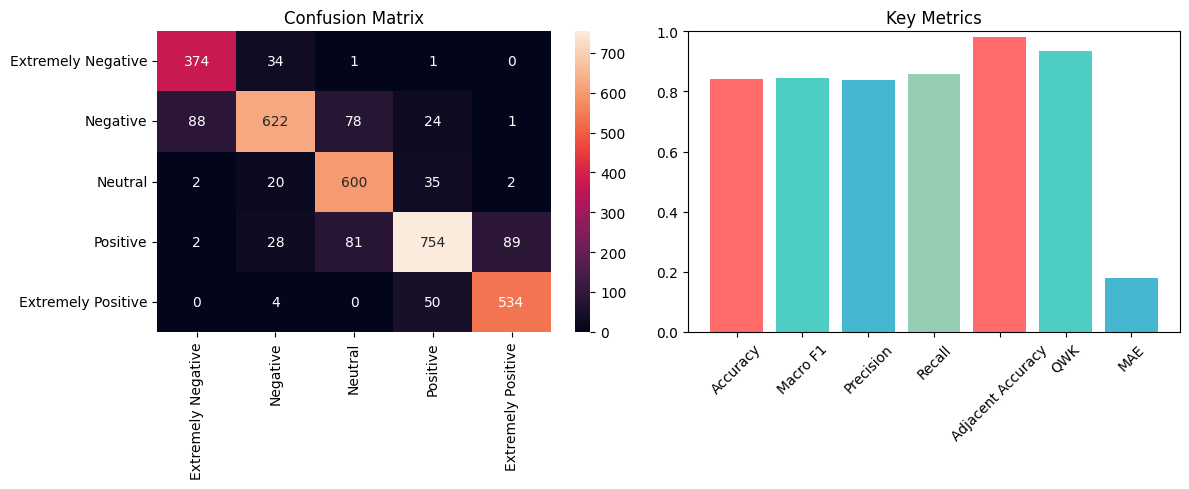

In [25]:
# Use the best model that was saved
optimal_batch_size = study.best_params['batch_size']
test_dataset = TweetDataset(test_encodings, test_labels)
test_loader = DataLoader(test_dataset, batch_size=optimal_batch_size, shuffle=False)

# Use the actual best model now
results = quick_eval_manual('best_model_optuna.pt', test_loader)

### Hyperparameter Tuning Results

In [26]:
# Check study results
print("=== STUDY RESULTS ===")
print(f"Best trial: {study.best_trial.number}")
print(f"Best QWK: {study.best_value:.4f}")
print(f"Best params: {study.best_params}")

# Compare all trials
print("\n=== ALL TRIALS ===")
for trial in study.trials:
    print(f"Trial {trial.number}: QWK = {trial.value:.4f}")

=== STUDY RESULTS ===
Best trial: 2
Best QWK: 0.9374
Best params: {'learning_rate': 4.7412352298523686e-05, 'batch_size': 16, 'label_smoothing': 0.14864590596800178, 'epochs': 12, 'warmup_ratio': 0.053072966467540166, 'weight_decay': 0.14067329738635054, 'attention_dropout': 0.31630050099253554, 'hidden_dropout': 0.30284169042309084}

=== ALL TRIALS ===
Trial 0: QWK = 0.9366
Trial 1: QWK = 0.9361
Trial 2: QWK = 0.9374
Trial 3: QWK = 0.9363
Trial 4: QWK = 0.9368
Trial 5: QWK = 0.9312
Trial 6: QWK = 0.9331
Trial 7: QWK = 0.0000


### Model Predictions Analysis

In [27]:
# Analyze what the best model is predicting
import torch
from torch.serialization import safe_globals
from transformers import RobertaForSequenceClassification

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the entire model directly
with safe_globals({RobertaForSequenceClassification}):
    model = torch.load('./best_bert_model_so_far/model_bert.pt', map_location=device, weights_only=False)

model.to(device)
model.eval()

# Calculate model metrics
model_size_mb = get_model_size(model)
total_params, trainable_params = get_model_parameters(model)

# Get a sample batch for inference timing
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
sample_batch = next(iter(val_loader))
inference_time_ms = measure_inference_time(model, sample_batch, device)

# Check predictions on validation data
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = outputs.logits.argmax(dim=-1)

        all_predictions.extend(predictions.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

# Analyze predictions
from collections import Counter
pred_dist = Counter(all_predictions)
true_dist = Counter(all_true_labels)

print("=== BEST MODEL ANALYSIS ===")
print("=" * 60)
print("MODEL SPECIFICATIONS:")
print(f"   • Model Size: {model_size_mb:.2f} MB")
print(f"   • Total Parameters: {total_params:,}")
print(f"   • Trainable Parameters: {trainable_params:,}")
print(f"   • Inference Time: {inference_time_ms:.2f} ms per request")
print("=" * 60)
print("PREDICTION ANALYSIS:")
print(f"   • True label distribution: {dict(true_dist)}")
print(f"   • Predicted label distribution: {dict(pred_dist)}")
print(f"   • Unique predictions: {sorted(set(all_predictions))}")
print(f"   • Number of classes predicted: {len(set(all_predictions))}")
print("=" * 60)

if len(set(all_predictions)) == 5:
    print("✅ Model is predicting all 5 classes!")
elif len(set(all_predictions)) > 1:
    print(f"✅ Model is predicting {len(set(all_predictions))} classes (better than before!)")
else:
    print("❌ Model still predicting only 1 class")

print(f"📊 Efficiency Metrics:")
print(f"   • Parameters per MB: {total_params/model_size_mb:,.0f}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


=== BEST MODEL ANALYSIS ===
MODEL SPECIFICATIONS:
   • Model Size: 514.62 MB
   • Total Parameters: 134,903,813
   • Trainable Parameters: 134,903,813
   • Inference Time: 202.11 ms per request
PREDICTION ANALYSIS:
   • True label distribution: {np.int64(2): 889, np.int64(1): 915, np.int64(3): 1275, np.int64(0): 488, np.int64(4): 790}
   • Predicted label distribution: {np.int64(2): 1019, np.int64(1): 805, np.int64(3): 1154, np.int64(0): 510, np.int64(4): 869}
   • Unique predictions: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
   • Number of classes predicted: 5
✅ Model is predicting all 5 classes!
📊 Efficiency Metrics:
   • Parameters per MB: 262,143
